In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

sns.set_theme()

In [2]:
fixed_effects = [
    'Country',
    'CCUS_sector',
    'Sector',
    'emissions_sector'
]

analytic_vars = [
    'Demand_electricity',
    'Demand_heat',
    'Demand_nuclear',
    'Demand_renewables_and_waste',
    'Supply_nuclear',
    'renewable_to_fossil_supply_ratio',
    'energy_demand_fossil_fuels',
    'CPI_growth',
    'GDP_per_capita_PPP',
    #'d_log_total_capacity'
]

df_filtered =  pd.read_csv('df-sub.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'df-sub.csv'

In [126]:
df_filtered = df_filtered.dropna()

# Finding a valid subset

In [5]:
ds_orig = pd.read_csv('df_merged_cleaned.csv')

In [6]:
import pandas as pd
import numpy as np

def subset_by_control_counts_with_diagnostics(df,
                                             treatment_var='d_log_eor_capacity',
                                             time_var='Year',
                                             group_vars=('Country', 'Sector'),
                                             min_clusters=5,
                                             min_obs=30,
                                             min_controls=10):
    """
    Filters df to (Country, Sector, Year) cells with sufficient not‐yet‐treated controls,
    and prints diagnostic info after each filtering step.
    """
    df = df.copy()
    # 1. Define treated indicator
    df['treated'] = (df[treatment_var] > 0).astype(int)

    # 2. Determine cohort year per group
    first_treat = (
        df[df['treated'] == 1]
        .groupby(list(group_vars))[time_var]
        .min()
        .reset_index(name='cohort')
    )
    all_grps = df[list(group_vars)].drop_duplicates()
    cohort = all_grps.merge(first_treat, on=list(group_vars), how='left')
    cohort['cohort'] = cohort['cohort'].fillna(np.inf)

    # 3. Overall group‐level counts
    group_stats = (
        df
        .groupby(list(group_vars))
        .agg(n_obs=('treated','size'),
             n_treated=('treated','sum'))
        .reset_index()
    )
    group_stats['sparsity'] = 1 - group_stats['n_treated'] / group_stats['n_obs']

    # 4. Apply min_clusters & min_obs filters
    valid_groups = group_stats[
        (group_stats['n_treated'] >= min_clusters) &
        (group_stats['n_obs'] >= min_obs)
    ][list(group_vars)]
    print("Groups after size filters:", valid_groups.shape[0])

    if valid_groups.empty:
        raise ValueError("No groups meet min_clusters/min_obs criteria")

    # 5. Restrict data and cohort to valid groups
    df2 = df.merge(valid_groups, on=list(group_vars), how='inner')
    cohort2 = cohort.merge(valid_groups, on=list(group_vars), how='inner')

    # 6. Compute control counts per (group, year)
    years = sorted(df2[time_var].unique())
    cells = []
    for _, row in cohort2.iterrows():
        key = {var: row[var] for var in group_vars}
        g_cohort = row['cohort']
        for yr in years:
            n_controls = (cohort2['cohort'] > yr).sum()
            cells.append({**key, time_var: yr, 'n_controls': n_controls})
    cell_stats = pd.DataFrame(cells)
    print("Total (group,year) cells:", cell_stats.shape[0])

    # 7. Apply control‐count filter
    keep_cells = cell_stats[cell_stats['n_controls'] >= min_controls]
    print("Cells with ≥ min_controls controls:", keep_cells.shape[0])

    if keep_cells.empty:
        raise ValueError("No (group, year) has ≥ min_controls controls")

    # 8. Filter original subset to kept cells
    df_keep = df2.merge(
        keep_cells[list(group_vars) + [time_var]],
        on=list(group_vars) + [time_var],
        how='inner'
    )
    print("Raw treated share:", df2['treated'].mean())
    print("Filtered treated share:", df_keep['treated'].mean())

    return {
        'filtered_df': df_keep,
        'group_stats': group_stats,
        'cell_stats': cell_stats,
        'keep_cells': keep_cells
    }

# Example usage:
results = subset_by_control_counts_with_diagnostics(
    ds_orig,
    treatment_var='d_log_eor_capacity',
    group_vars=('Country','Sector'),
    min_clusters=5,
    min_obs=30,
    min_controls=10
)

print("\nKept cells:\n", results['keep_cells'])
print("Filtered data shape:", results['filtered_df'].shape)


Groups after size filters: 18
Total (group,year) cells: 774
Cells with ≥ min_controls controls: 720
Raw treated share: 0.05113459581177786
Filtered treated share: 0.043133581928420955

Kept cells:
            Country                               Sector  Year  n_controls
0           Canada  Commercial and public services (PJ)  1980          18
1           Canada  Commercial and public services (PJ)  1981          18
2           Canada  Commercial and public services (PJ)  1982          17
3           Canada  Commercial and public services (PJ)  1983          17
4           Canada  Commercial and public services (PJ)  1984          17
..             ...                                  ...   ...         ...
766  United States                       Transport (PJ)  2015          10
767  United States                       Transport (PJ)  2016          10
768  United States                       Transport (PJ)  2017          10
769  United States                       Transport (PJ)  2018 

In [234]:
did_balance_report(
    ds_orig, 
    cluster_col='Country_Sector',    # or None if you don't have clusters
    time_col='Year',
    treatment_var='d_log_eor_capacity',
    outcome_col='d_log_emissions'
)

Total observations: 4350516
Time span: 1980 – 2022 (43 periods)
Overall treated proportion: 0.45%

Treatment share by year:
Year
1980    0.000000
1981    0.000000
1982    0.000012
1983    0.000000
1984    0.000000
1985    0.000000
1986    0.002651
1987    0.002598
1988    0.002599
1989    0.002588
1990    0.002551
1991    0.002548
1992    0.002542
1993    0.002313
1994    0.002213
1995    0.002196
1996    0.002111
1997    0.002106
1998    0.002069
1999    0.002123
2000    0.002131
2001    0.002112
2002    0.002051
2003    0.002043
2004    0.002024
2005    0.002007
2006    0.001986
2007    0.001982
2008    0.001980
2009    0.001976
2010    0.003897
2011    0.005961
2012    0.005933
2013    0.009758
2014    0.009971
2015    0.010014
2016    0.009917
2017    0.009699
2018    0.009663
2019    0.009649
2020    0.011659
2021    0.013540
2022    0.015411

No valid cluster_col provided; skipping cluster diagnostics.

---
MDE (80% power, 5% α): 0.019 SDs of `d_log_emissions`
(clusters used: 435

In [261]:
get_VIF_values(results['filtered_df'], analytic_vars)

,Variable,VIF
0,const,7.055001
5,Supply_nuclear,4.601664
9,GDP_per_capita_PPP,3.981642
3,Demand_nuclear,3.371420
1,Demand_electricity,2.880131
7,energy_demand_fossil_fuels,2.862842
2,Demand_heat,1.478798
8,CPI_growth,1.195283
4,Demand_renewables_and_waste,1.182997
6,renewable_to_fossil_supply_ratio,1.136585


,Variable,VIF
0,const,7.055001
5,Supply_nuclear,4.601664
9,GDP_per_capita_PPP,3.981642
3,Demand_nuclear,3.371420
1,Demand_electricity,2.880131
7,energy_demand_fossil_fuels,2.862842
2,Demand_heat,1.478798
8,CPI_growth,1.195283
4,Demand_renewables_and_waste,1.182997
6,renewable_to_fossil_supply_ratio,1.136585


In [271]:
import numpy as np

def did_balance_report(
    df, 
    cluster_col=None, 
    time_col='Year', 
    treatment_var='d_log_eor_capacity',
    outcome_col='d_log_emissions',
    alpha=0.05,
    power=0.8
):
    """
    Checks panel balance, treatment assignment (continuous d_log_eor_capacity → binary),
    and reports MDE for DiD.

    Parameters:
        df: DataFrame with time_col, treatment_var, outcome_col (and optional cluster_col).
        cluster_col: Column identifying clusters (e.g. 'Country_Sector'). If None or absent, skips clustering diagnostics.
        time_col: Column with time periods (e.g. 'Year').
        treatment_var: Continuous treatment variable; defines treated = (treatment_var > 0).
        outcome_col: Outcome variable name (default 'd_log_emissions').
        alpha: Significance level (default 0.05).
        power: Statistical power (default 0.8).
    """
    df = df.copy()
    # 1. Define binary treated indicator
    df['treated'] = (df[treatment_var] > 0).astype(int)
    
    # 2. Basic panel info
    N = len(df)
    years = sorted(df[time_col].unique())
    print(f"Total observations: {N}")
    print(f"Time span: {years[0]} – {years[-1]} ({len(years)} periods)")
    
    # 3. Treatment prevalence
    prop_treated = df['treated'].mean()
    print(f"Overall treated proportion: {prop_treated:.2%}")
    print("\nTreatment share by year:")
    print(df.groupby(time_col)['treated'].mean().to_string())
    
    # 4. Cluster diagnostics (if cluster_col provided)
    if cluster_col and cluster_col in df.columns:
        clusters = df[cluster_col].nunique()
        ever = df.groupby(cluster_col)['treated'].max()
        print(f"\nNumber of clusters: {clusters}")
        print(f"Ever-treated clusters: {(ever>0).sum()}, Never-treated: {(ever==0).sum()}")
        print("\nObs per cluster (largest 5):")
        print(df.groupby(cluster_col).size().nlargest(5).to_string())
        print("\nObs per cluster (smallest 5):")
        print(df.groupby(cluster_col).size().nsmallest(5).to_string())
        both = df.groupby([cluster_col, time_col])['treated'].nunique() > 1
        print(f"\nCluster–year cells with both treated & control: {both.sum()}")
    else:
        print("\nNo valid cluster_col provided; skipping cluster diagnostics.")
    # After min_clusters/min_obs:
    print("Groups after size filters:", valid_groups.shape[0])
    
    # After building cell_stats:
    print("Total (group,year) cells:", cell_stats.shape[0])
    print("Cells with ≥ min_controls controls:", keep_cells.shape[0])
    
    # Compute treatment ratio before vs. after:
    print("Raw treated share:", df2['treated'].mean())
    print("Filtered treated share:", df_keep['treated'].mean())

    # 5. MDE calculation
    # z-scores for two-sided test at given alpha & power
    z_alpha = 1.96  # for alpha=0.05
    z_power = 0.84  # for power=0.8
    
    n_periods = len(years)
    n_clusters = df[cluster_col].nunique() if (cluster_col and cluster_col in df.columns) else N
    var_y = df[outcome_col].var()
    eff_n = n_clusters * n_periods * prop_treated * (1 - prop_treated)
    
    if eff_n <= 0 or var_y == 0 or np.isnan(var_y):
        print("\nCannot compute MDE: insufficient variation or zero outcome variance.")
        return
    
    mde = (z_alpha + z_power) * np.sqrt(4 * var_y / eff_n)
    print("\n---")
    print(f"MDE (80% power, 5% α): {mde:.3f} SDs of `{outcome_col}`")
    print(f"(clusters used: {n_clusters}, periods: {n_periods}, treated prop.: {prop_treated:.2%})")

did_balance_report(
    df, 
    cluster_col='Country_Sector',    # or None if you don't have clusters
    time_col='Year',
    treatment_var='d_log_eor_capacity',
    outcome_col='d_log_emissions'
)


Total observations: 86464
Time span: 1980 – 2022 (43 periods)
Overall treated proportion: 19.14%

Treatment share by year:
Year
1980    0.000000
1981    0.000000
1982    0.000000
1983    0.000000
1984    0.000000
1985    0.000000
1986    0.165056
1987    0.165056
1988    0.165056
1989    0.165056
1990    0.163596
1991    0.165056
1992    0.167295
1993    0.160595
1994    0.159175
1995    0.155061
1996    0.155061
1997    0.155061
1998    0.155061
1999    0.154060
2000    0.154060
2001    0.154060
2002    0.155732
2003    0.131307
2004    0.133746
2005    0.130356
2006    0.130356
2007    0.129886
2008    0.129886
2009    0.125506
2010    0.190392
2011    0.252948
2012    0.253908
2013    0.257176
2014    0.257624
2015    0.257915
2016    0.257176
2017    0.238505
2018    0.238389
2019    0.237738
2020    0.238006
2021    0.267165
2022    0.274603

No valid cluster_col provided; skipping cluster diagnostics.


NameError: name 'valid_groups' is not defined

In [270]:
did_balance_report(
    results['filtered_df'], 
    cluster_col='Country_Sector',    # or None if you don't have clusters
    time_col='Year',
    treatment_var='d_log_eor_capacity',
    outcome_col='d_log_emissions'
)


Total observations: 342726
Time span: 1980 – 2019 (40 periods)
Overall treated proportion: 4.31%

Treatment share by year:
Year
1980    0.000000
1981    0.000000
1982    0.000133
1983    0.000000
1984    0.000000
1985    0.000000
1986    0.028638
1987    0.028638
1988    0.028638
1989    0.028638
1990    0.028244
1991    0.028638
1992    0.028660
1993    0.027864
1994    0.027481
1995    0.026906
1996    0.026906
1997    0.026906
1998    0.026549
1999    0.026890
2000    0.027011
2001    0.026890
2002    0.026726
2003    0.025751
2004    0.025955
2005    0.025424
2006    0.025424
2007    0.025263
2008    0.025263
2009    0.024840
2010    0.046095
2011    0.067829
2012    0.068308
2013    0.102174
2014    0.102870
2015    0.102870
2016    0.102266
2017    0.098180
2018    0.097713
2019    0.097164

No valid cluster_col provided; skipping cluster diagnostics.

---
MDE (80% power, 5% α): 0.035 SDs of `d_log_emissions`
(clusters used: 342726, periods: 40, treated prop.: 4.31%)


In [7]:
treatment_rat = lambda x: int((x['d_log_eor_capacity'] > 0).mean() * 100)

In [8]:
treatment_rat(results['filtered_df']), len(results['filtered_df'])

(4, 342726)

In [264]:
ds_orig['d_log_eor_capacity'].unique()

array([ 0.        ,  2.4510051 ,  0.26236426,  0.83290912, -0.83290912,
        0.69314718,  0.09531018,  0.08701138, -0.08701138,  0.51082562,
       -0.597837  ,  0.47000363,  0.14842001,  0.27002714, -0.27002714,
       -0.12160713,  0.12160713, -0.14842001,  0.51879379,  0.12306009,
       -0.12306009, -0.25642953,  0.37948962,  1.09861229, -1.09861229,
       -0.10536052,  1.2039728 ,  1.2660082 , -1.37136871, -0.86222351,
       -0.23638878,  1.38629436, -0.74444047,  0.74444047, -1.38629436])

In [268]:
treatment_rat(ds_orig), len(ds_orig)

(0, 4350516)

In [267]:
import pandas as pd

def subset_by_control_counts(df,
                             treatment_var='d_log_eor_capacity',
                             time_var='Year',
                             group_vars=('Country', 'Sector'),
                             min_clusters=5,
                             min_obs=30,
                             min_controls=10):
    """
    Filters df to (Country, Sector, Year) cells with sufficient not‐yet‐treated controls:
      1. Define treated cohort: first Year with treatment_var > 0.
      2. Cohort g_i = first treated Year for each group; never‐treated get cohort = inf.
      3. For each (group, year), count controls = number of other groups with cohort > year.
      4. Require:
         - Each group has ≥ min_clusters treated obs.
         - Each group has ≥ min_obs total obs.
         - Each (group, year) cell has controls ≥ min_controls.
    Returns:
      filtered_df: only rows in kept cells
      group_stats: overall stats by group
      cell_stats: controls count per (group, year)
      keep_cells: (group, year) cells to keep
    """
    df = df.copy()
    # 1. binary treated indicator
    df['treated'] = (df[treatment_var] > 0).astype(int)

    # 2. cohort year per group
    cohort = (
        df[df['treated'] == 1]
        .groupby(list(group_vars))[time_var]
        .min()
        .reset_index(name='cohort')
    )
    # never treated groups
    all_grps = df[group_vars].drop_duplicates()
    cohort = all_grps.merge(cohort, on=list(group_vars), how='left')
    cohort['cohort'] = cohort['cohort'].fillna(float('inf'))

    # 3. overall group‐level counts
    group_stats = (
        df
        .groupby(list(group_vars))
        .agg(n_obs=('treated','size'),
             n_treated=('treated','sum'))
        .reset_index()
    )
    group_stats['sparsity'] = 1 - group_stats['n_treated'] / group_stats['n_obs']

    # 4. apply min_clusters & min_obs
    valid_groups = group_stats[
        (group_stats['n_treated'] >= min_clusters) &
        (group_stats['n_obs'] >= min_obs)
    ][group_vars]
    if valid_groups.empty:
        raise ValueError("No groups meet min_clusters/min_obs criteria")

    # restrict to valid groups
    df2 = df.merge(valid_groups, on=list(group_vars), how='inner')
    cohort2 = cohort.merge(valid_groups, on=list(group_vars), how='inner')

    # 5. compute controls per (group, year)
    years = sorted(df2[time_var].unique())
    cells = []
    for _, row in cohort2.iterrows():
        grp = tuple(row[var] for var in group_vars)
        g_cohort = row['cohort']
        for yr in years:
            # count other groups with cohort > yr
            n_controls = (cohort2['cohort'] > yr).sum()
            cells.append({
                **{var: grp[i] for i, var in enumerate(group_vars)},
                time_var: yr,
                'n_controls': n_controls
            })
    cell_stats = pd.DataFrame(cells)

    # 6. keep cells with enough controls
    keep_cells = cell_stats[cell_stats['n_controls'] >= min_controls]
    if keep_cells.empty:
        raise ValueError("No (group, year) has ≥ min_controls controls")

    # 7. filter original df
    key_cols = list(group_vars) + [time_var]
    df_keep = df2.merge(keep_cells[key_cols], on=key_cols, how='inner')

    return {
        'filtered_df': df_keep,
        'group_stats': group_stats,
        'cell_stats': cell_stats,
        'keep_cells': keep_cells
    }

# Example usage:
results = subset_by_control_counts(
    ds_orig,
    treatment_var='d_log_eor_capacity',
    group_vars=['Country','Sector'],
    min_clusters=5,
    min_obs=30,
    min_controls=10
)

print("Kept cells:\n", results['keep_cells'])
print("Filtered data shape:", results['filtered_df'].shape)


Kept cells:
            Country                               Sector  Year  n_controls
0           Canada  Commercial and public services (PJ)  1980          18
1           Canada  Commercial and public services (PJ)  1981          18
2           Canada  Commercial and public services (PJ)  1982          17
3           Canada  Commercial and public services (PJ)  1983          17
4           Canada  Commercial and public services (PJ)  1984          17
..             ...                                  ...   ...         ...
766  United States                       Transport (PJ)  2015          10
767  United States                       Transport (PJ)  2016          10
768  United States                       Transport (PJ)  2017          10
769  United States                       Transport (PJ)  2018          10
770  United States                       Transport (PJ)  2019          10

[720 rows x 4 columns]
Filtered data shape: (342726, 55)


In [260]:
results['filtered_df']

,Unnamed: 0,Year,Country,Sector,Demand_coal_peat_and_oil_shale,Demand_crude_ngl_and_feedstocks,Demand_electricity,Demand_heat,Demand_natural_gas,Demand_nuclear,...,log_unknown_capacity,d_log_unknown_capacity,d_log_unknown_capacity_norm,log_mixed_co2_capacity,d_log_mixed_co2_capacity,d_log_mixed_co2_capacity_norm,eor_capacity_norm,renewable_to_fossil_supply_ratio,energy_demand_fossil_fuels,treated
0,896184,1980,Canada,Commercial and public services (PJ),0.001416,0.000000,0.341233,0.001430,0.384928,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.047589,-0.340663,0
1,896526,1980,Canada,Industry (PJ),0.081804,0.000000,0.232994,0.020057,0.323672,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.047589,-0.492041,0
2,896868,1980,Canada,Other final consumption (PJ),0.009079,0.000000,0.047858,0.000000,0.184989,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.047589,0.925336,0
3,897210,1980,Canada,Residential (PJ),0.002724,0.000000,0.257734,0.000000,0.309071,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.047589,-0.011112,0
4,897552,1980,Canada,Total energy supply (PJ),0.107187,0.494614,-0.012203,0.000000,0.237366,0.054171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.047589,-2.145204,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342721,5116961,2019,United States,Residential (PJ),0.000000,0.000000,0.456281,0.000000,0.436181,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.279370,-0.819487,0
342722,5117834,2019,United States,Total energy supply (PJ),0.124297,0.443808,0.001518,0.000000,0.335611,0.099349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.279370,-2.373799,0
342723,5117835,2019,United States,Total energy supply (PJ),0.124297,0.443808,0.001518,0.000000,0.335611,0.099349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.279370,-2.373799,0
342724,5118708,2019,United States,Transport (PJ),0.000000,0.000000,0.001877,0.000000,0.036964,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.279370,1.550845,0


In [165]:
results['filtered_df'].to_csv('subset_new.csv')

In [166]:
subset_new = results['filtered_df']

In [106]:
# Sort data first
df_merged_cleaned = df.copy()
capacity_cols = [c for c in df_merged_cleaned.columns if 'capacity' in c and 'total' in c]

df_merged_cleaned = df_merged_cleaned.sort_values(['Country', 'CCUS_sector', 'Year'])

# Calculate year-over-year differences
group_cols = ['Country', 'CCUS_sector']

for c in capacity_cols:
    df_merged_cleaned[f'log_{c}'] = np.log1p(df_merged_cleaned[c].copy())
    
    df_merged_cleaned[f'd_log_{c}'] = df_merged_cleaned.groupby(group_cols)[f'log_{c}'].diff().fillna(0)

    scale_em = (
        df_merged_cleaned
        .groupby(group_cols)[f'd_log_{c}']
        .transform(lambda x: x.abs().max())
    )

df_merged_cleaned.to_csv('dataset.csv')

C:\Users\rjsou\Documents\Generation-Forecasting\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rjsou\Documents\Generation-Forecasting\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rjsou\Documents\Generation-Forecasting\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [249]:
# 1. Inspect how many groups survive the size & coverage filters
print("Total distinct Country–Sector groups:", grp.shape[0])
print("Groups after min_clusters/min_obs/min_coverage filters:", grp_filtered.shape[0])

# 2. Summarize the distribution of “good_years” across surviving groups
print("\nDistribution of good_years (sparsity ≤ 0.10):")
print(good_counts['good_years'].value_counts().sort_index())

# 3. Check the max “good_years” any group attains
print("\nMax good_years for any group:", good_counts['good_years'].max())


Total distinct Country–Sector groups: 37


NameError: name 'grp_filtered' is not defined

In [109]:
a = df

len(df['Country'].unique()), df['Year'].unique()

(3,
 array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
        1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
        2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]))

In [110]:
treatment_ratio = (df['d_log_total_capacity'] > 0).mean()
print(f"Treatment ratio in focused subset: {treatment_ratio:.2%}")

Treatment ratio in focused subset: 10.19%


In [113]:
(df['d_log_eor_capacity'] > 0).sum() / (df['d_log_eor_capacity'] > 0).count()

np.float64(0.09062616344005957)

In [114]:
df_filtered.drop(
    columns=[
        'Unnamed: 0.1',
        'Unnamed: 0'
    ]
).to_csv('dataset-subset.csv')

KeyError: "['Unnamed: 0.1'] not found in axis"

In [242]:
# Focus on high-treatment regions to increase signal-to-noise ratio
df_filtered = df[  
    (df['Country'].isin(['United States', 'Canada', 'China'])) &  
    (df['CCUS_sector'].isin([  
        'Natural gas processing/LNG',  
        'Chemicals',  
        'Biofuels',
        'Other fuel transformation'
    ]))  
]  

# Recalculate treatment coverage
treatment_ratio = (df_filtered['d_log_eor_capacity'] > 0.0).mean()
print(f"Treatment ratio in focused subset: {treatment_ratio:.2%}")


Treatment ratio in focused subset: 10.11%


In [116]:
treatment_rat(df_filtered)

9

In [8]:
(df_filtered['d_log_eor_capacity'] > 0.0).mean()

np.float64(0.10110853877278606)

In [142]:
analytic_vars = [p for p in df_filtered.columns if 'demand' in p.lower() or 'supply' in p.lower() and 'to_' not in p or 'CPI' in p or 'GDP' in p or 'pop' in p and p != 'GDP_PPP'] 

# Verifying

In [31]:
analytic_vars = [p for p in df_filtered.columns if 'demand' in p.lower() or 'supply' in p.lower() and 'to_' not in p or 'CPI' in p or 'GDP' in p or 'pop' in p and p != 'GDP_PPP'] 

['Demand_electricity', 'Demand_heat', 'Demand_nuclear', 'Demand_renewables_and_waste', 'Supply_nuclear', 'renewable_to_fossil_supply_ratio', 'energy_demand_fossil_fuels', 'CPI_growth', 'GDP_per_capita_PPP']


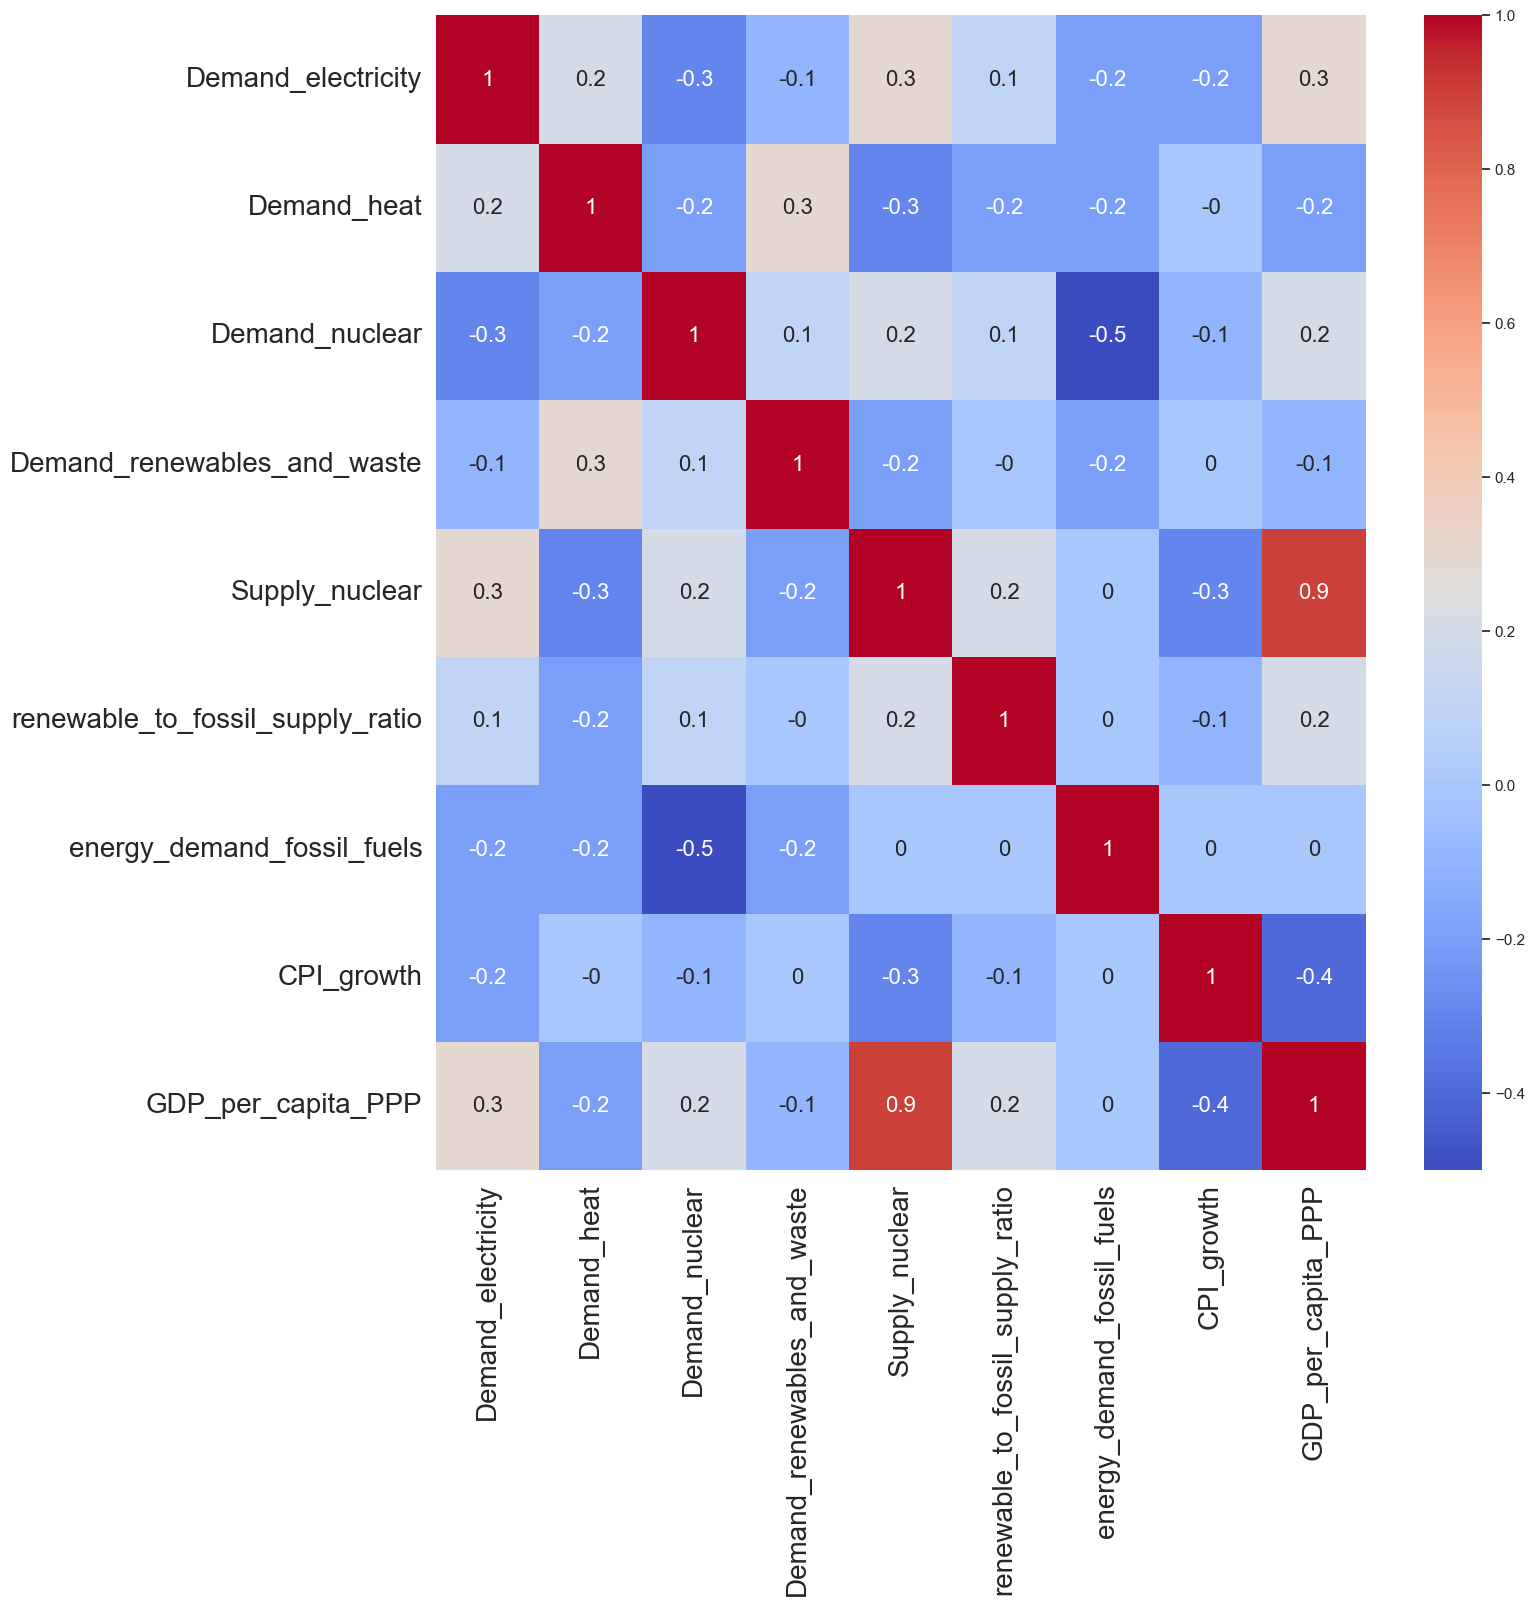

In [117]:
get_correlation_matrix(df_filtered, analytic_vars, 'corr_after.png')

In [96]:
analytic_vars.extend(['OECD', 'd_log_eor_capacity'])

In [176]:
redundant = ['log_log_total_capacity',
             'd_log_log_total_capacity',
             'log_d_log_total_capacity',
             'd_log_d_log_total_capacity']
df_reduced = subset_new.drop(columns=redundant)


In [185]:
df_reduced = df_reduced.drop(
    columns=[
        'Unnamed: 0.1',
        'Unnamed: 0',
        'd_log_total_capacity',
        'eor_capacity_norm',
        'log_emissions',
        'd_log_emissions_norm',
        'emissions_norm',
        'log_dedicated_storage_capacity',
        'log_use_capacity',
        'log_unknown_capacity',
        'log_mixed_co2_capacity',
        'treated',
        'total_capacity',
        'use_capacity',
        'eor_capacity',
        'unknown_capacity',
        'mixed_co2_capacity'
    ]
)

In [187]:
g = df_reduced.groupby(['Country', 'Sector'])['d_log_eor_capacity']
dense_cells = (g.mean() > 0).sum()   # ≥10 % treated rows
print(f"Dense cells (>10% treated): {dense_cells} / {g.ngroups}")


Dense cells (>10% treated): 6 / 6


In [188]:
get_VIF_values_panel(df_reduced, analytic_vars)

,Variable,VIF
0,GDP_per_capita_PPP,32.761416
1,Supply_nuclear,30.430540
2,renewable_to_fossil_supply_ratio,20.579771
3,Demand_nuclear,15.734463
4,Demand_electricity,14.981819
5,energy_demand_fossil_fuels,12.900125
6,Demand_renewables_and_waste,3.919088
7,CPI_growth,3.636855
8,Demand_heat,2.629385


In [189]:
get_VIF_values(df_reduced, analytic_vars)

,Variable,VIF
0,const,310.731805
3,Demand_nuclear,13.364826
7,energy_demand_fossil_fuels,12.477370
1,Demand_electricity,7.544097
9,GDP_per_capita_PPP,4.637063
6,renewable_to_fossil_supply_ratio,2.982332
5,Supply_nuclear,2.962418
8,CPI_growth,2.400183
2,Demand_heat,1.996008
4,Demand_renewables_and_waste,1.863893


,Variable,VIF
0,const,310.731805
3,Demand_nuclear,13.364826
7,energy_demand_fossil_fuels,12.477370
1,Demand_electricity,7.544097
9,GDP_per_capita_PPP,4.637063
6,renewable_to_fossil_supply_ratio,2.982332
5,Supply_nuclear,2.962418
8,CPI_growth,2.400183
2,Demand_heat,1.996008
4,Demand_renewables_and_waste,1.863893


In [47]:
plot_faceted_normalized_emissions_and_capacity(df_subset, save_path='trends.png')


NameError: name 'plot_faceted_normalized_emissions_and_capacity' is not defined

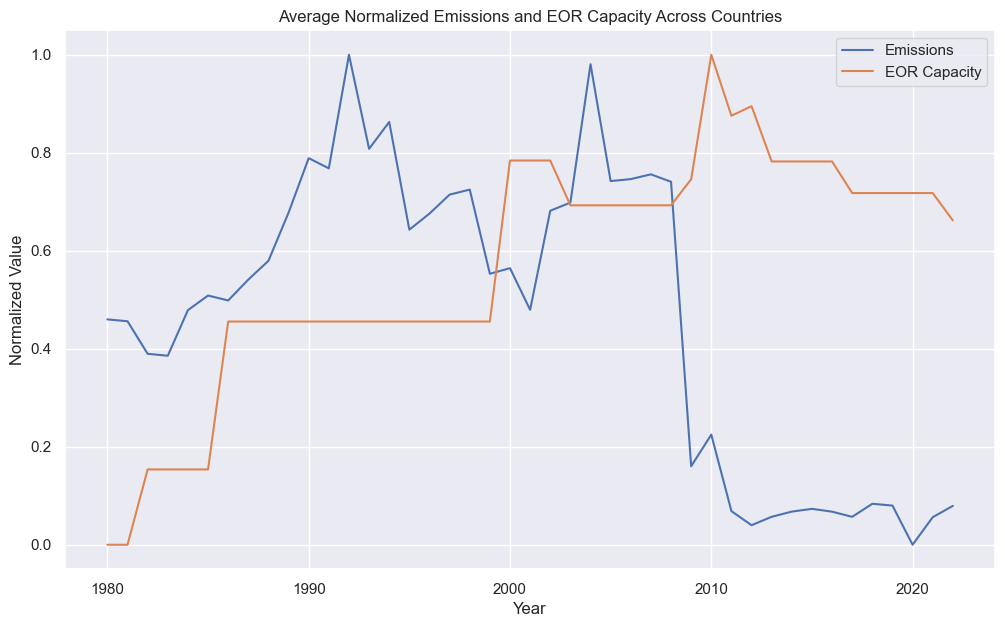

In [121]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df = df_subset.copy()
df = df[df['Country'] == 'United States']
emissions_norm = df[['log_emissions', 'Year', 'log_eor_capacity']].groupby(['Year']).mean()
emissions_norm[['log_emissions', 'log_eor_capacity']] = scaler.fit_transform(emissions_norm[['log_emissions', 'log_eor_capacity']])

# After your normalization step
emissions_norm_reset = emissions_norm.reset_index()
emissions_yearly = emissions_norm_reset.groupby('Year')[['log_emissions', 'log_eor_capacity']].mean().reset_index()

plt.figure(figsize=(12, 7))
sns.lineplot(data=emissions_yearly, x='Year', y='log_emissions', label='Emissions')
sns.lineplot(data=emissions_yearly, x='Year', y='log_eor_capacity', label='EOR Capacity')
plt.ylabel('Normalized Value')
plt.title('Average Normalized Emissions and EOR Capacity Across Countries')
plt.show()


In [122]:
scaler = MinMaxScaler()
df_subset.loc[df_subset['Country'] == 'United States', 'Emissions_norm'] = scaler.fit_transform(
    df_subset.loc[df_subset['Country'] == 'United States', ['Emissions']]
)

scaler = MinMaxScaler()
df_subset.loc[df_subset['Country'] == 'China', 'Emissions_norm'] = scaler.fit_transform(
    df_subset.loc[df_subset['Country'] == 'China', ['Emissions']]
)

scaler = MinMaxScaler()
df_subset.loc[df_subset['Country'] == 'Canada', 'Emissions_norm'] = scaler.fit_transform(
    df_subset.loc[df_subset['Country'] == 'Canada', ['Emissions']]
)

C:\Users\rjsou\AppData\Local\Temp\ipykernel_39292\2134271686.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(


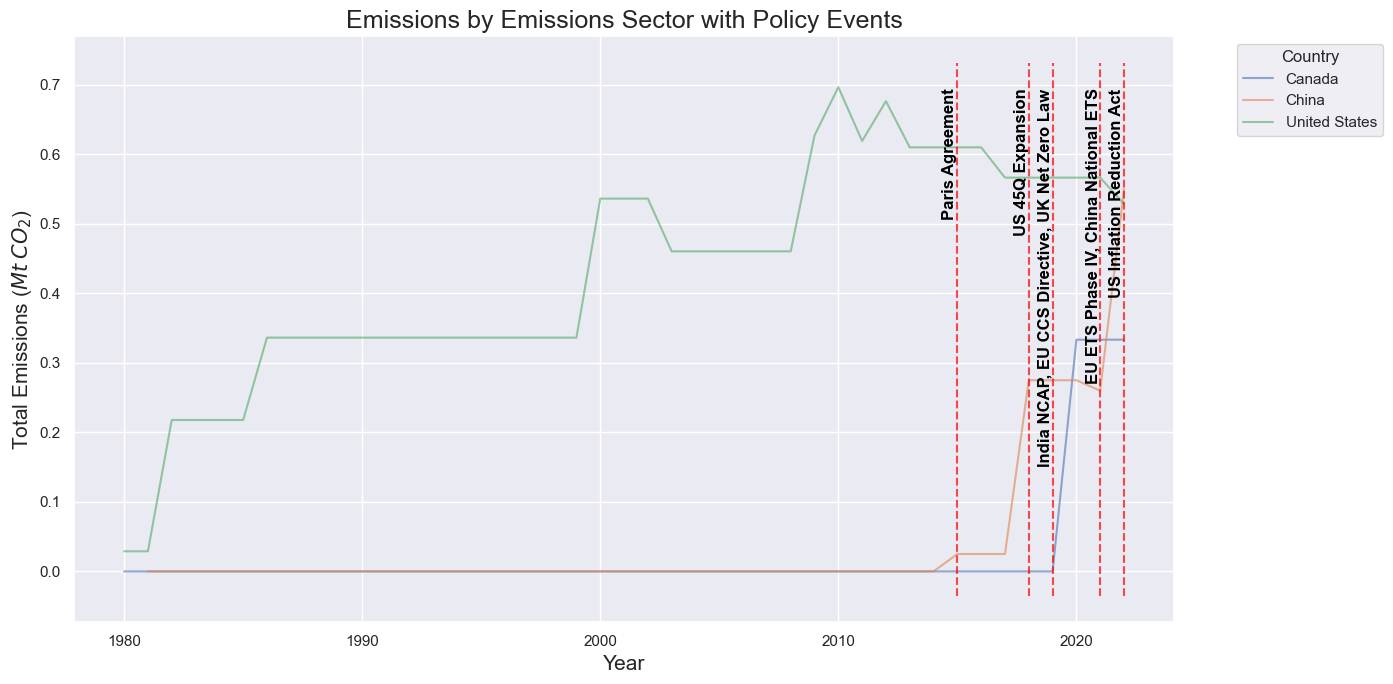

In [123]:
plot_by_sector_with_policies(
     df_subset,
     value_col='eor_capacity_norm',
     sector_col='Country',
     year_col='Year', 
     policy_dates=updated_policy_dates,
     ylabel=r'Total Emissions ($Mt \; CO_2$)', 
     title='Emissions by Emissions Sector with Policy Events'
 )

# Utils

In [22]:
def get_correlation_matrix(df, columns, save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    print(columns)
    corr = df[columns].corr().round(1)
    
    sns.heatmap(
        data=corr,
        cmap='coolwarm',
        annot=True,
        ax=ax,
        annot_kws={"size": 16},
    )

    ax.tick_params(axis='both', which='major', labelsize=20)  # Font size for tick labels

    corr.to_csv('corr.csv')

    if save_path:
        plt.savefig(save_path, dpi=250, bbox_inches='tight')
    plt.show()


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

def get_GVIF_values(df, predictors, name='abc'):
    # Select predictors present in the dataframe
    X = df[[p for p in predictors if p in df.columns]]
    
    # Identify categorical variables by dtype
    categorical_vars = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # One-hot encode categorical variables with drop_first=True
    X = pd.get_dummies(X, columns=categorical_vars, drop_first=True).astype(float)
    
    # Add constant term for intercept
    X = add_constant(X)
    
    # Map dummy columns back to their original variable for grouping
    dummy_to_var = {}
    for var in categorical_vars:
        for col in X.columns:
            if col.startswith(var + '_'):
                dummy_to_var[col] = var
    # Non-dummy columns (continuous or constant) map to themselves
    for col in X.columns:
        if col not in dummy_to_var and col != 'const':
            dummy_to_var[col] = col
    
    # Group columns by their original variable
    groups = {}
    for col, var in dummy_to_var.items():
        groups.setdefault(var, []).append(col)
    
    gvif_results = []
    for var, cols in groups.items():
        if len(cols) == 1:
            # Single variable: standard VIF
            y = X[cols]
            X_others = X.drop(columns=cols)
            model = OLS(y, X_others).fit()
            r2 = model.rsquared
            vif = 1 / (1 - r2) if r2 < 1 else np.inf
            gvif_results.append({'Variable': var, 'GVIF': vif, 'Df': 1})
        else:
            # Multiple dummies: use max VIF among dummies as GVIF approximation
            vifs = []
            for col in cols:
                y = X[col]
                X_others = X.drop(columns=cols)
                model = OLS(y, X_others).fit()
                r2 = model.rsquared
                vif = 1 / (1 - r2) if r2 < 1 else np.inf
                vifs.append(vif)
            max_vif = max(vifs)
            gvif_results.append({'Variable': var, 'GVIF': max_vif, 'Df': len(cols)})
    
    gvif_df = pd.DataFrame(gvif_results).sort_values(by='GVIF', ascending=False)
    gvif_df.to_csv(f'{name}_gvif.csv', index=False)
    display(gvif_df)
    return gvif_df


In [51]:
import pandas as pd
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_VIF_values(df, predictors, name='abc'):
    # Select predictors present in the dataframe
    X = df[[p for p in predictors if p in df.columns]]
    
    # One-hot encode categorical variables and convert all to float
    X = pd.get_dummies(X, drop_first=True).astype(float)
    
    # Add constant term for intercept
    X = add_constant(X)
    
    # Calculate VIF for each variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Sort by VIF descending and display
    sorted_vif = vif_data.sort_values(by="VIF", ascending=False)
    sorted_vif.to_csv(f'{name}.csv')
    display(sorted_vif)

    return sorted_vif


In [231]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_VIF_values_panel(df, analytic_vars):
    """
    Calculate VIF for a panel dataset using only specified analytic variables.
    
    Parameters:
    - df (pd.DataFrame): Your panel data (already filtered for relevant rows).
    - analytic_vars (list of str): List of variable names to include in the VIF check.
    
    Returns:
    - pd.DataFrame with Variable and VIF columns, sorted by VIF descending.
    """
    # Subset and clean
    X = df[analytic_vars].copy()
    X = X.fillna(0)  # Drop missing values (you could also fillna if appropriate)

    # Optionally center variables to reduce numerical issues (not strictly required)
    # X = (X - X.mean())  # Optional centering

    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)


In [48]:
def get_VIF_values(df, predictors):
    
    X = df[[p for p in predictors if p in df.columns]]
    X = add_constant(X)
    
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    
    vif_data.sort_values(by="VIF", ascending=False).to_markdown(buf='abc.md')
    display(vif_data.sort_values(by="VIF", ascending=False))
    

In [8]:
def plot_by_sector_with_policies(
    df,
    value_col='Value',
    sector_col='Sector',
    year_col='Year',
    policy_dates=None,
    ylabel='Value',
    title='Trends by Sector'
):
    # Prepare a clean dict of scalar policy years
    clean_policies = {}
    if policy_dates:
        for event, yr in policy_dates.items():
            # Force into a 1D numpy array then take its first element
            yr_arr = np.atleast_1d(yr)
            yr0 = yr_arr[0] if yr_arr.size > 0 else np.nan
            # Coerce to numeric, invalid → NaN
            yr_num = pd.to_numeric(yr0, errors='coerce')  # :contentReference[oaicite:0]{index=0}
            # Keep only finite values
            if np.isfinite(yr_num):                       # :contentReference[oaicite:1]{index=1}
                clean_policies[event] = float(yr_num)
    policy_dates = clean_policies

    plt.figure(figsize=(12, 7))
    ax = sns.lineplot(
        data=df,
        x=year_col,
        y=value_col,
        hue=sector_col,
        ci=None,
        #errorbar='sd',         # standard-deviation bands :contentReference[oaicite:2]{index=2}
        legend='full',
        alpha=0.6
    )

    # Annotate policy dates with vertical lines (data coordinates)
    ymin, ymax = ax.get_ylim()
    for event, yr in policy_dates.items():
        ax.vlines(x=yr, ymin=ymin, ymax=ymax,
                  color='red', linestyle='--', alpha=0.7)  # :contentReference[oaicite:3]{index=3}
        ax.text(yr, ymax * 0.95, event, rotation=90,
                va='top', ha='right', fontsize=12, color='black', fontweight='bold')

    ax.set_xlabel(year_col, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_title(title, fontsize=18)
    plt.tight_layout()
    plt.legend(title=sector_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

updated_policy_dates = {
    'Paris Agreement': 2015,
    'EU ETS Phase IV, China National ETS': 2021,
    'US 45Q Expansion': 2018,
    #'EU CBAM, Japan GX League': 2023,
    'US Inflation Reduction Act': 2022,
    'India NCAP, EU CCS Directive, UK Net Zero Law': 2019,
}

# DR DiD

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import time
def implement_dr_did(df, outcome_var="log_emissions", 
                    treatment_var="d_log_eor_capacity", 
                    post_var="post",
                    covariates=None,
                    start_year=2012, nb=0, tb=0):
    """
    Implements Doubly Robust DiD based on Sant'Anna and Zhao (2020)
    
    Parameters:
    -----------
    df : DataFrame
        Dataset containing treatment, outcome, and covariates
    outcome_var : str
        Name of outcome variable (e.g., log_emissions)
    treatment_var : str
        Name of treatment variable (e.g., d_log_eor_capacity)
    post_var : str
        Name of post-treatment indicator (e.g., post)
    covariates : list
        List of covariate names to include
        
    Returns:
    --------
    dict
        Dictionary containing ATT estimate and diagnostics
    """
    # 1. Create binary treatment indicator
    df = df.copy()
    df['treated'] = (df[treatment_var] > 0).astype(int)
    
    # If no covariates specified, use VIF-appropriate ones
    if covariates is None:
        covariates = ['Demand_electricity', 'Demand_heat', 
                      'Demand_renewables_and_waste', 
                      'renewable_to_fossil_supply_ratio',
                      'CPI_growth']
        
    # 2. Split data into pre and post periods
    df_pre = df[df['Year'] < 2012]
    df_post = df[df['Year'] > 2012]
    
    # 3. Estimate propensity scores using pre-treatment covariates
    ps_model = LogisticRegression(max_iter=1000, class_weight='balanced')
    X_pre = df_pre[covariates].fillna(0)
    ps_model.fit(X_pre, df_pre['treated'])
    
    # Predict propensity scores
    ps_pre = ps_model.predict_proba(df_pre[covariates].fillna(0))[:, 1]
    ps_post = ps_model.predict_proba(df_post[covariates].fillna(0))[:, 1]
    
    # 4. Trim extreme propensity scores to avoid numerical issues
    eps = 0.01
    ps_pre = np.clip(ps_pre, eps, 1-eps)
    ps_post = np.clip(ps_post, eps, 1-eps)
    
    # 5. Estimate outcome models for treated and control groups
    treated_pre = df_pre[df_pre['treated'] == 1]
    control_pre = df_pre[df_pre['treated'] == 0]
    
    # Check if we have enough treated observations for reliable estimation
    if len(treated_pre) > 5:
        #print(f'{nb}/{tb}: Loading model for pre treated', end='\r')
        #time.sleep(10000)
        # Outcome model for treated group
        print( f"{outcome_var} ~ {' + '.join(covariates)}")
        out_model_treat = smf.ols(
            f"{outcome_var} ~ {' + '.join(covariates)}", data=treated_pre
        ).fit(cov_type='cluster', cov_kwds={'groups': df_subset['Country']})

        print(  f"{outcome_var} ~ {' + '.join(covariates)}")
        # Outcome model for control group
        out_model_control = smf.ols(
            f"{outcome_var} ~ {' + '.join(covariates)}", data=control_pre
        ).fit(cov_type='cluster', cov_kwds={'groups': df_subset['Country']})

        
        # 6. Compute counterfactual predictions
        mu_treat_pre = out_model_treat.predict(df_pre)
        mu_control_pre = out_model_control.predict(df_pre)
        mu_treat_post = out_model_treat.predict(df_post)
        mu_control_post = out_model_control.predict(df_post)
        
        # 7. Compute the Augmented Inverse Probability Weighting (AIPW) estimator
        ipw_pre = df_pre['treated'] / ps_pre - (1 - df_pre['treated']) / (1 - ps_pre)
        ipw_post = df_post['treated'] / ps_post - (1 - df_post['treated']) / (1 - ps_post)
        
        # Outcome regression component
        outcome_pre = mu_treat_pre - mu_control_pre
        outcome_post = mu_treat_post - mu_control_post
        
        # Doubly robust component
        dr_pre = np.mean(outcome_pre + ipw_pre * (df_pre[outcome_var] - 
                        df_pre['treated'] * mu_treat_pre - 
                        (1 - df_pre['treated']) * mu_control_pre))
        dr_post = np.mean(outcome_post + ipw_post * (df_post[outcome_var] - 
                         df_post['treated'] * mu_treat_post - 
                         (1 - df_post['treated']) * mu_control_post))
        
        # ATT = difference in doubly robust estimators
        att = dr_post - dr_pre
        
        
    return {  # Return dict without bootstrap results
        'att': att,
        'n_treated_pre': len(treated_pre),
        'n_control_pre': len(control_pre),
        'ps_mean_treated': np.mean(ps_pre[df_pre['treated'] == 1]),
        'ps_mean_control': np.mean(ps_pre[df_pre['treated'] == 0])
    }

from copy import deepcopy
from tqdm import tqdm

def bootstrap_dr_did(df, outcome_var="log_emissions",
                    treatment_var="d_log_eor_capacity",
                    covariates=None,
                    start_year=2012,
                    n_bootstrap=100):
    """Memory-efficient bootstrap implementation"""
    atts = []
    ps_means = []
    errors = 0
    
    for _ in tqdm(range(n_bootstrap)):
        # 1. Resample with replacement
        boot_idx = np.random.choice(df.index, size=len(df), replace=True)
        df_boot = df.loc[boot_idx].copy()
        
        # 2. Run DR DiD
        try:
            res = implement_dr_did(
                df_boot, outcome_var, treatment_var, 
                covariates, start_year
            )
            if not np.isnan(res['att']) and res['n_treated_pre'] >= 5:
                atts.append(res['att'])
                ps_means.append(res['ps_mean_treated'])
        except Exception as e:
            errors += 1
            continue
    
    # 3. Calculate CIs using percentile method
    print(f"Bootstrap failure rate: {errors/n_bootstrap:.1%}")
    if len(atts) < 10:  # Require min 10 successful bootstraps
        return {
            'att': np.nan,
            'ci_lower': np.nan,
            'ci_upper': np.nan,
            'p_value': np.nan
        }

    
    return {
        'att': np.mean(atts),
        'ci_lower': np.percentile(atts, 2.5),
        'ci_upper': np.percentile(atts, 97.5),
        'p_value': (np.sum(np.array(atts) < 0) / len(atts)),
        'bootstrap_ps_mean': np.mean(ps_means)
    }



In [10]:
# Define your subset of data with 7.33% treatment ratio
df_subset = df_filtered.copy()

# Run the DR-DiD estimation
result = bootstrap_dr_did(
    df_subset,
    outcome_var="d_log_emissions",
    treatment_var="d_log_total_capacity",
    covariates=analytic_vars,
    n_bootstrap=100,
)

print("Average Treatment Effect on Treated (ATT):", result['att'])
print(f"95% Confidence Interval: [{result['ci_lower']}, {result['ci_upper']}]")
print("p-value:", result['p_value'])


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.07it/s]

Bootstrap failure rate: 100.0%
Average Treatment Effect on Treated (ATT): nan
95% Confidence Interval: [nan, nan]
p-value: nan


# Debugging

In [15]:
df_subset['treated'] = df_subset['Year'] >= 2012

In [97]:
len(df_subset[df_subset['Year'] < 2012]), len(df_subset[df_subset['Year'] >= 2012])

(119268, 72516)

In [37]:
print("Treatment values:\n", df_subset[['d_log_total_capacity', 'treated']].describe())
print("Zero-dose treatment %:", 
      (df_subset['d_log_eor_capacity'] == 0).mean() * 100)


Treatment values:
        d_log_total_capacity
count         191784.000000
mean               0.000027
std                0.528131
min               -1.735293
25%                0.000000
50%                0.000000
75%                0.000000
max                1.945910
Zero-dose treatment %: 76.09915321403246


Issue: 76% zero-dose → insufficient treated units.
- Solution: aggregate into cohorts

In [49]:
def get_VIF_values(df, predictors):
    
    X = df[[p for p in predictors if p in df.columns]]
    X = add_constant(X)
    
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    
    vif_data.sort_values(by="VIF", ascending=False).to_markdown(buf='abc.md')
    display(vif_data.sort_values(by="VIF", ascending=False))

    
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(df_subset[analytic_vars].fillna(0).values, i) 
       for i in range(len(analytic_vars))]

for f, v in zip(analytic_vars, vif):
    print(f, v)

Demand_electricity 5.409534025445035
Demand_heat 1.5788164471266064
Demand_nuclear 4.049652061463613
Demand_renewables_and_waste 1.5064017239964784
Supply_nuclear 13.110582165561919
renewable_to_fossil_supply_ratio 1.5613113378154433
energy_demand_fossil_fuels 3.259645428792084
CPI_growth 1.356553950593118
GDP_per_capita_PPP 10.287528895826942


In [37]:
# Better approach
complete_data = df_subset[analytic_vars].fillna(0)
vif = [variance_inflation_factor(complete_data.values, i) 
       for i in range(len(analytic_vars))]


In [39]:
df_subset[analytic_vars].fillna(0)

,Demand_electricity,Demand_heat,Demand_nuclear,Demand_renewables_and_waste,Supply_nuclear,renewable_to_fossil_supply_ratio,energy_demand_fossil_fuels,CPI_growth,GDP_per_capita_PPP
0,0.341233,0.001430,0.000000,0.000000,0.101887,3.047589,-0.340663,10.183,11811.175
1,0.232994,0.020057,0.000000,0.110003,0.101887,3.047589,-0.492041,10.183,11811.175
2,0.047858,0.000000,0.000000,0.000000,0.101887,3.047589,0.925336,10.183,11811.175
3,0.257734,0.000000,0.000000,0.067517,0.101887,3.047589,-0.011112,10.183,11811.175
4,-0.012203,0.000000,0.054171,0.152339,0.101887,3.047589,-2.145204,10.183,11811.175
...,...,...,...,...,...,...,...,...,...
191779,0.001631,0.000000,0.096366,0.088297,0.179675,0.355708,-2.370865,2.097,69004.241
191780,0.002326,0.000000,0.000000,0.060130,0.179675,0.355708,1.493263,2.097,69004.241
191781,0.002326,0.000000,0.000000,0.060130,0.179675,0.355708,1.493263,2.097,69004.241
191782,0.002326,0.000000,0.000000,0.060130,0.179675,0.355708,1.493263,2.097,69004.241


In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(df_subset[analytic_vars].fillna(0)[analytic_vars].fillna(0).values, i) 
       for i in range(len(analytic_vars))]

for f, v in zip(analytic_vars, vif):
    print(f, v)

Demand_electricity 5.409534025445035
Demand_heat 1.5788164471266064
Demand_nuclear 4.049652061463613
Demand_renewables_and_waste 1.5064017239964784
Supply_nuclear 13.110582165561919
renewable_to_fossil_supply_ratio 1.5613113378154433
energy_demand_fossil_fuels 3.259645428792084
CPI_growth 1.356553950593118
GDP_per_capita_PPP 10.287528895826942


In [43]:
from pyfixest import feols

# Event study model
model = feols(
    f'd_log_emissions ~ i(event_time, treated) + {' + '.join(analytic_vars)} | Country + Year',
    data=df_subset
)
model.plot(coefplot=True)


C:\Users\rjsou\Documents\Generation-Forecasting\venv\Lib\site-packages\pyfixest\estimation\feols_.py:2628: UserWarning: 
            43 variables dropped due to multicollinearity.
            The following variables are dropped: 
    C(event_time)[-10]:treated
    C(event_time)[-9]:treated
    C(event_time)[-8]:treated
    C(event_time)[-7]:treated
    C(event_time)[-6]:treated
    ....
            
  warnings.warn(


AttributeError: 'Feols' object has no attribute 'plot'

# Callaway

Recommendation: Switch to cohort aggregation with Callaway's approach

Reasons:
1. Your 100% bootstrap failure rate indicates instability in the DR-DiD implementation
2. High sparsity (76% zeros) makes cohort aggregation more appropriate
3. From the histogram, your treatment has limited support points

In [54]:
df = df_filtered.copy()
# Define treatment indicator (binary)
df['treated'] = (df['d_log_eor_capacity'] != 0).astype(int)

# Create first treatment year variable ("cohort")
df['first_treat_year'] = np.nan

# For each country, find the first year with non-zero treatment
for country in df['Country'].unique():
    treatment_years = df[(df['Country']==country) & (df['treated']==1)]['Year']
    if len(treatment_years) > 0:
        first_year = treatment_years.min()
        df.loc[df['Country']==country, 'first_treat_year'] = first_year
    else:
        # Never-treated units get a value beyond the study period
        df.loc[df['Country']==country, 'first_treat_year'] = np.inf


In [55]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define treatment and first treatment year
def prepare_event_study_data(df, treatment_var='d_log_eor_capacity', year_var='Year', threshold=0):
    """
    Prepares dataset for event study by identifying first treatment year and calculating event time.
    
    Parameters:
    -----------
    df : DataFrame
        Raw dataset containing treatment and outcome variables
    treatment_var : str
        Name of the continuous treatment variable
    year_var : str
        Name of the year variable
    threshold : float
        Threshold above which to consider a unit treated
        
    Returns:
    --------
    DataFrame
        Dataset with event study variables added
    """
    # Make a copy to avoid modifying the original
    event_df = df.copy()
    
    # Create binary treatment indicator for treated units
    event_df['treated'] = (event_df[treatment_var] > threshold).astype(int)
    
    # Identify first treatment year for each panel (only where treatment is nonzero)
    # Group by all panel identifiers (adjust as needed for your data structure)
    panel_vars = ['Country', 'CCUS_sector', 'emissions_sector', 'Sector']
    
    # Identify the first treatment year for each panel unit
    treatments = event_df[event_df[treatment_var] != 0].copy()
    first_treat = (treatments
                  .groupby(panel_vars)[year_var]
                  .min()
                  .reset_index()
                  .rename(columns={year_var: 'first_treat_year'}))
    
    # Merge first treatment year back to the original data
    event_df = pd.merge(event_df, first_treat, on=panel_vars, how='left')
    
    # Compute event time: year relative to first treatment year
    event_df['event_time'] = event_df[year_var] - event_df['first_treat_year']
    
    return event_df

# 2. Define event time indicators and interactions
def create_event_indicators(df, pre_window=5, post_window=10):
    """
    Creates event-time indicators for DiD regression.
    
    Parameters:
    -----------
    df : DataFrame
        Dataset with event_time variable
    pre_window : int
        Number of pre-treatment periods to include
    post_window : int
        Number of post-treatment periods to include
        
    Returns:
    --------
    tuple
        DataFrame with indicators, list of interaction terms
    """
    # Filter to relevant event window
    event_df = df[(df['event_time'] >= -pre_window) & (df['event_time'] <= post_window)].copy()
    
    # Create event time indicators (exclude k = -1 as base period)
    interaction_terms = []
    
    for k in range(-pre_window, post_window+1):
        if k == -1:
            continue  # Skip the reference period
            
        # Create suffix for variable names
        suffix = f"n{-k}" if k < 0 else f"{k}"
        
        # Create indicator for this event time
        event_df[f'att_{suffix}'] = (event_df['event_time'] == k).astype(int)
        
        # Create interaction with treatment intensity
        event_df[f'dose_att_{suffix}'] = event_df[f'att_{suffix}'] * event_df['d_log_eor_capacity']
        interaction_terms.append(f'dose_att_{suffix}')
    
    return event_df, interaction_terms

# 3. Run the event study regression
def run_event_study(df, outcome_var='d_log_emissions', fe_vars=None):
    """
    Runs event study regression with fixed effects.
    
    Parameters:
    -----------
    df : DataFrame
        Dataset with event study indicators
    outcome_var : str
        Name of the outcome variable
    fe_vars : list
        List of variables to use as fixed effects
        
    Returns:
    --------
    statsmodels results
    """
    if fe_vars is None:
        fe_vars = ['Country', 'Year', 'CCUS_sector', 'emissions_sector', 'Sector']
    
    # Get list of event-time interactions
    interaction_cols = [col for col in df.columns if col.startswith('dose_att_')]
    
    # Build the regression formula with fixed effects
    formula = f"{outcome_var} ~ " + " + ".join(interaction_cols)
    for var in fe_vars:
        formula += f" + C({var})"
    
    # Fit the model with cluster-robust SE by Country
    model = smf.ols(formula, data=df).fit(
        cov_type='cluster',
        cov_kwds={'groups': df['Country']}
    )
    
    return model

# 4. Plot the event study results
def plot_event_study(model, interaction_terms):
    """
    Creates event study plot with confidence intervals.
    
    Parameters:
    -----------
    model : statsmodels results
        Fitted regression model
    interaction_terms : list
        List of interaction terms in the model
    """
    # Extract coefficients and standard errors
    coef = model.params.filter(items=interaction_terms)
    coef_se = model.bse.filter(items=interaction_terms)
    
    # Parse event times from interaction term names
    event_times = []
    for term in interaction_terms:
        suffix = term.replace('dose_att_', '')
        if suffix.startswith('n'):
            event_times.append(-int(suffix[1:]))
        else:
            event_times.append(int(suffix))
    
    # Sort by event time
    sorted_indices = sorted(range(len(event_times)), key=lambda i: event_times[i])
    sorted_event_times = [event_times[i] for i in sorted_indices]
    sorted_coef = [coef.iloc[i] for i in sorted_indices]
    sorted_se = [coef_se.iloc[i] for i in sorted_indices]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(sorted_event_times, sorted_coef, yerr=[1.96*se for se in sorted_se], 
                 fmt='o', capsize=5, label='ATT estimates with 95% CI')
    
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.axvline(x=-1, color='red', linestyle='--', alpha=0.3, label='Reference period (t=-1)')
    
    plt.xlabel('Event Time (Years Relative to Treatment)')
    plt.ylabel('Effect on Emissions (log points)')
    plt.title('Event Study: Impact of EOR Capacity on Emissions')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 5. Main function to run the complete event study
def main_event_study(df, treatment_var='d_log_eor_capacity', outcome_var='d_log_emissions',
                    year_var='Year', pre_window=5, post_window=10):
    """
    Runs a complete event study analysis from raw data.
    
    Parameters:
    -----------
    df : DataFrame
        Raw dataset
    treatment_var : str
        Name of the treatment variable
    outcome_var : str
        Name of the outcome variable
    year_var : str
        Name of the year variable
    pre_window : int
        Number of pre-treatment periods to include
    post_window : int
        Number of post-treatment periods to include
    
    Returns:
    --------
    tuple
        Model results and processed dataframe
    """
    # Step 1: Prepare event study data
    print("Preparing event study data...")
    event_df = prepare_event_study_data(df, treatment_var, year_var)
    
    # Step 2: Create event indicators
    print("Creating event time indicators...")
    event_df, interaction_terms = create_event_indicators(event_df, pre_window, post_window)
    
    # Print summary statistics
    print(f"Total observations: {len(event_df)}")
    print(f"Observations in event window: {len(event_df[~event_df['event_time'].isna()])}")
    print(f"Number of treated units: {event_df['treated'].sum()}")
    
    # Step 3: Run the regression
    print("Running event study regression...")
    model = run_event_study(event_df, outcome_var)
    
    # Step 4: Plot the results
    print("Creating event study plot...")
    plot_event_study(model, interaction_terms)
    
    return model, event_df


Preparing event study data...
Creating event time indicators...
Total observations: 40105
Observations in event window: 40105
Number of treated units: 10562
Running event study regression...
Creating event study plot...


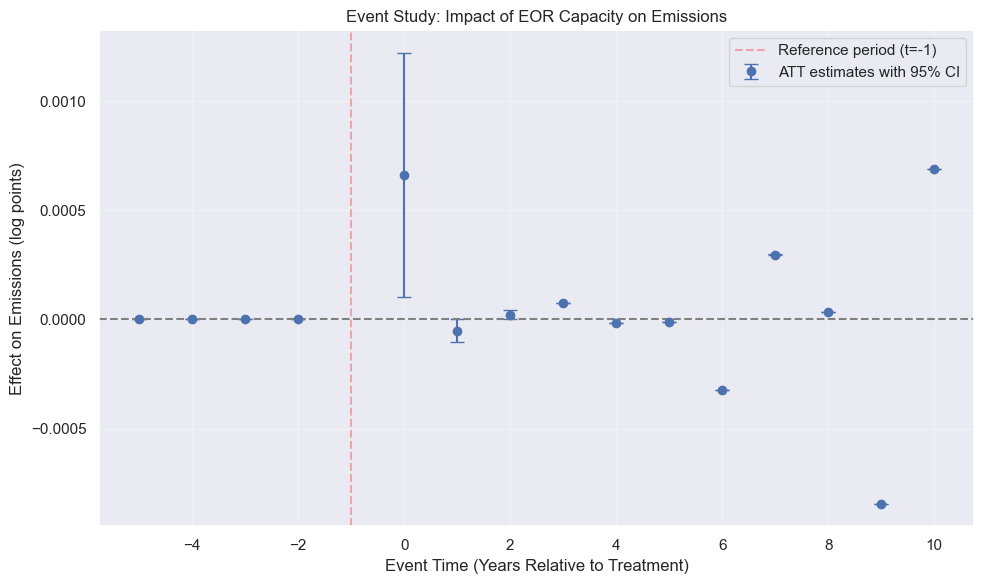

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x18c7b4470b0>,
         Unnamed: 0  Year        Country                               Sector  \
 18288       444192  2015         Canada  Commercial and public services (PJ)   
 18528       444432  2016         Canada  Commercial and public services (PJ)   
 18768       444672  2017         Canada  Commercial and public services (PJ)   
 19008       444912  2018         Canada  Commercial and public services (PJ)   
 19248       445152  2019         Canada  Commercial and public services (PJ)   
 ...            ...   ...            ...                                  ...   
 191779     4339429  2022  United States             Total energy supply (PJ)   
 191780     4339430  2022  United States                       Transport (PJ)   
 191781     4339431  2022  United States                       Transport (PJ)   
 191782     4339432  2022  United States                       Transport (PJ)   
 191783     4339433  2022  

In [56]:
main_event_study(df_filtered)

In [57]:
import numpy as np

df = df_filtered.copy()
# Define first treatment year for each panel (where treatment is nonzero)
panel_vars = ['Country', 'CCUS_sector', 'emissions_sector', 'Sector']
# 1. Define a clear binary treatment indicator
df['treated'] = (df['d_log_eor_capacity'] != 0).astype(int)

# 2. Identify first treatment year for each panel unit
first_treat = df[df['treated'] == 1].groupby('Country')['Year'].min().reset_index()
first_treat.rename(columns={'Year': 'first_treat_year'}, inplace=True)

# 3. Merge first treatment year back to main dataframe
df = df.merge(first_treat, on='Country', how='left')

# 4. Create binned cohort groups to reduce sparsity
# Option A: Exact years (if treatment timing is not too sparse)
df['cohort'] = df['first_treat_year']

# Option B: Grouped cohorts (better for sparse treatment)
df['cohort_group'] = pd.cut(
    df['first_treat_year'], 
    bins=[2000, 2010, 2015, 2020, 2025],  # Adjust based on your data
    labels=['2000-2010', '2011-2015', '2016-2020', '2021-2025']
)

# 5. Create numeric cohort values for PyFixest
# PyFixest requires numeric values for the second parameter in i()
cohort_dict = {group: i for i, group in enumerate(df['cohort_group'].unique())}
df['cohort_numeric'] = df['cohort_group'].map(cohort_dict)

# 6. Handle never-treated units
df.loc[df['first_treat_year'].isna(), 'cohort_numeric'] = -1  # Special value for never-treated

# 7. Calculate event time
df['event_time'] = df['Year'] - df['first_treat_year']

# 8. Restrict to reasonable event window
df_analysis = df[(df['event_time'].between(-5, 5)) | (df['first_treat_year'].isna())]


In [58]:
import pandas as pd
import numpy as np
from pyfixest import feols

# 1. More clearly define treatment
df = df_filtered.copy()
df['treated'] = (df['d_log_eor_capacity'] != 0)  # Focus on non-zero capacity changes

# 2. Create better cohort groups - use actual years, not infinite values
df['first_treat_year'] = np.nan
for country in df['Country'].unique():
    # Find first year with non-zero treatment
    treatment_years = df[(df['Country']==country) & df['treated']]['Year']
    if not treatment_years.empty:
        first_year = treatment_years.min()
        df.loc[df['Country']==country, 'first_treat_year'] = first_year
    
# 3. Create a categorical cohort variable that groups countries by treatment timing
# For countries with treatment, group into meaningful cohorts (early/mid/late adopters)
df['cohort_group'] = 'Never Treated'
df.loc[~df['first_treat_year'].isna(), 'cohort_group'] = pd.cut(
    df.loc[~df['first_treat_year'].isna(), 'first_treat_year'],
    bins=[2000, 2010, 2015, 2020, 2025],
    labels=['2000-2010', '2011-2015', '2016-2020', '2021-2025']
)

# 4. Calculate event time relative to first treatment
df['event_time'] = df['Year'] - df['first_treat_year']

# 5. Limit to a reasonable event window
df_analysis = df[df['event_time'].between(-5, 10)]

# 6. Simplify your model specification - use categorical cohort groups
# Reference event time -1 (year before treatment)
if len(df_analysis) > 0:
    model = feols(
        'd_log_emissions ~ i(event_time, ref=-1) + Demand_heat + renewable_to_fossil_supply_ratio + CPI_growth | Country + Year', 
        data=df_analysis,
        vcov={"CRV1": "Country"}
    )
    print(model.summary())
    
    # For a cohort-specific analysis, use:
    model_cohorts = feols(
        'd_log_emissions ~ i(event_time, cohort_group) + Demand_heat + renewable_to_fossil_supply_ratio + CPI_growth | Country + Year', 
        data=df_analysis,
        vcov={"CRV1": "Country"}
    )
    print(model_cohorts.summary())
else:
    print("No observations in event window. Check your cohort assignment.")


C:\Users\rjsou\Documents\Generation-Forecasting\venv\Lib\site-packages\pyfixest\estimation\feols_.py:2628: UserWarning: 
            10 variables dropped due to multicollinearity.
            The following variables are dropped: 
    C(event_time, contr.treatment(base=-1))[T.3.0]
    C(event_time, contr.treatment(base=-1))[T.4.0]
    C(event_time, contr.treatment(base=-1))[T.5.0]
    C(event_time, contr.treatment(base=-1))[T.6.0]
    C(event_time, contr.treatment(base=-1))[T.7.0]
    ....
            
  warnings.warn(

KeyboardInterrupt



In [ ]:
def plot_raw_trends(df, outcome_var='d_log_emissions', time_var='Year', 
                   group_var='treated', event_time_var='event_time',
                   event_window=(-5, 10)):
    
    # Filter to relevant event window
    plot_data = df[(df[event_time_var] >= event_window[0]) & 
                   (df[event_time_var] <= event_window[1])].copy()
    
    # Group by event time and treatment status
    trends = plot_data.groupby([event_time_var, group_var])[outcome_var].mean().reset_index()
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Plot treated and untreated groups
    sns.lineplot(data=trends, x=event_time_var, y=outcome_var, hue=group_var, 
                 marker='o', linewidth=2)
    
    # Add vertical line at treatment time
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    
    # Highlight pre-treatment period
    plt.axvspan(event_window[0], 0, alpha=0.1, color='gray')
    
    # Improve appearance
    plt.xlabel('Event Time (Periods Relative to Treatment)', fontsize=12)
    plt.ylabel('Outcome Variable', fontsize=12)
    plt.title('Raw Trends: Testing Parallel Trends Assumption', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Add annotations
    plt.annotate('Treatment', xy=(0, trends[outcome_var].min()), 
                 xytext=(0, trends[outcome_var].min()-0.01), 
                 ha='center', va='top', rotation=90, color='red')
    
    plt.legend(title='Group', loc='best')
    plt.tight_layout()
    
    return plt
plot_raw_trends(df)

In [ ]:
plt.figure(figsize=(10, 6), dpi=250)
plt.errorbar(periods, coefficients, yerr=1.96*std_errors,
             fmt='o', capsize=5, capthick=2, linewidth=2, markersize=8,
             color='#1f77b4', ecolor='#aec7e8')
plt.plot(periods, coefficients)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.xlabel('Years Relative to Treatment (t=0)', fontsize=28)
plt.ylabel(r'Treatment Effect ($Mt \; CO_2$)', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=22)
#plt.axvline(0, color='grey', ls='--', lw=1)
plt.savefig('Figures/toy_att_scores.png', dpi=250, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Sun & Abraham

In [41]:
import numpy as np
import pandas as pd

# Assume df_filtered is your panel dataset with columns: Country, Year, d_log_eor_capacity, etc.

# Step 1: Identify first treatment year for each unit (cohort)
df = df_filtered.copy()
df['treated'] = (df['d_log_eor_capacity'] != 0).astype(int)
first_treat = df[df['treated'] == 1].groupby('Country')['Year'].min().reset_index()
first_treat.rename(columns={'Year': 'first_treat_year'}, inplace=True)
df = df.merge(first_treat, on='Country', how='left')

# Step 2: Define cohort (first_treat_year) and event_time (relative to first treatment)
df['cohort'] = df['first_treat_year']
df['event_time'] = df['Year'] - df['first_treat_year']

pta_df = df[df['event_time'].between(-5, -1)]



In [58]:
from pyfixest import feols

# Controls: use your analytic_vars list
controls = ' + '.join(analytic_vars)

# Sun & Abraham's saturated event study formula:
formula = f'd_log_emissions ~ i(event_time, cohort) + {controls} | Country + Year'

# Estimate on pre-treatment periods
pta_model = feols(
    formula,
    data=pta_df,
    vcov={"CRV1": "emissions_sector"}
)
print(pta_model.summary())


C:\Users\rjsou\Documents\Generation-Forecasting\venv\Lib\site-packages\pyfixest\estimation\feols_.py:2628: UserWarning: 
            12 variables dropped due to multicollinearity.
            The following variables are dropped: 
    Supply_nuclear
    renewable_to_fossil_supply_ratio
    CPI_growth
    GDP_per_capita_PPP
    Country[T.China]
    ....
            
  warnings.warn(


###

Estimation:  OLS
Dep. var.: d_log_emissions, Fixed effects: Country+Year
Inference:  CRV1
Observations:  15792

| Coefficient                 |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:----------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Demand_electricity          |      0.032 |        0.012 |     2.698 |      0.011 |  0.008 |   0.056 |
| Demand_heat                 |     -0.058 |        0.025 |    -2.356 |      0.024 | -0.109 |  -0.008 |
| Demand_nuclear              |      0.123 |        0.048 |     2.554 |      0.015 |  0.025 |   0.221 |
| Demand_renewables_and_waste |     -0.005 |        0.002 |    -2.269 |      0.029 | -0.010 |  -0.001 |
| energy_demand_fossil_fuels  |      0.001 |        0.001 |     2.446 |      0.019 |  0.000 |   0.003 |
---
RMSE: 5.428 R2: 0.0 R2 Within: 0.0 
None


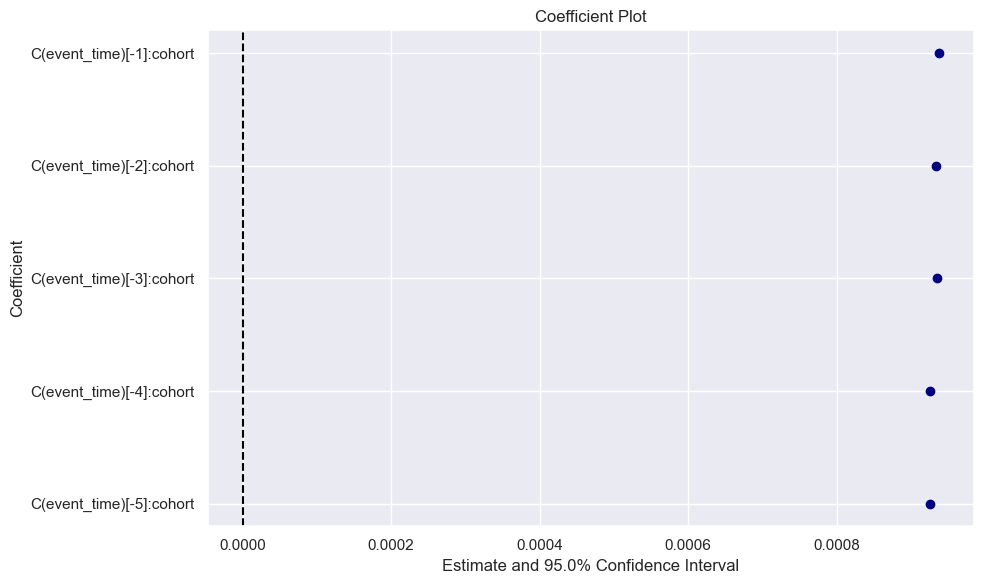

In [35]:
pta_model.iplot()

In [28]:
pta_model.coefplot()

C:\Users\rjsou\AppData\Local\Temp\ipykernel_6716\381825265.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pta_model.coefplot().show()


No pre-trend coefficients found for testing


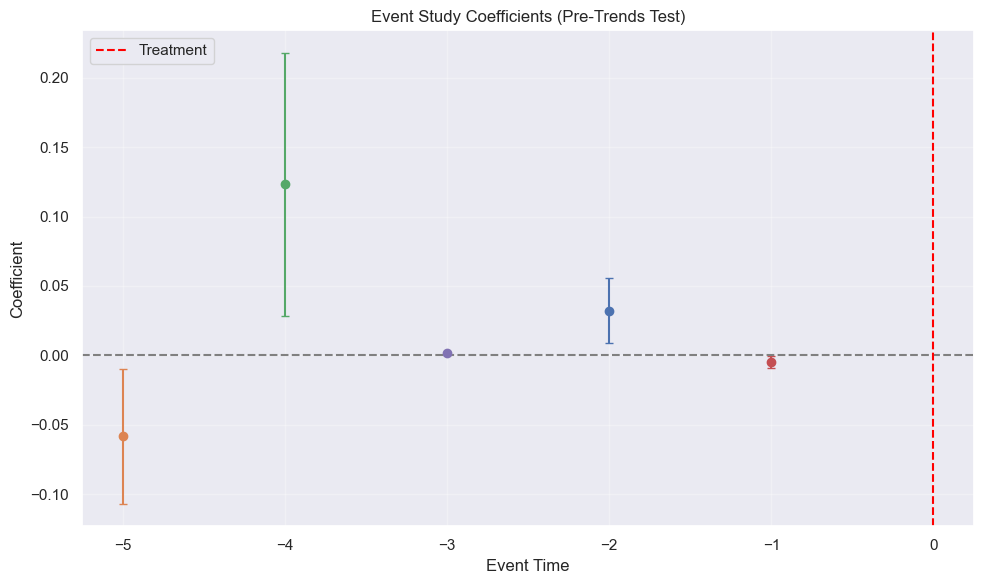

In [72]:
from scipy import stats
import numpy as np

# Extract pre-trend coefficients and standard errors (adjust pattern as needed)
pre_coefs = []
pre_ses = []

for key in pta_model.coef().keys():
    if 'event_time' in key and 'treatment' in key:
        try:
            # Extract the time value - adjust this based on your actual coefficient names
            time_str = key.split('[T.')[1].split(']')[0]
            time_val = float(time_str)
            
            # Check if this is a pre-treatment period (negative time, not base period)
            if time_val < 0 and time_val != -1:  # assuming -1 is your base period
                pre_coefs.append(model.coef[key])
                pre_ses.append(model.se[key])
        except (IndexError, ValueError):
            continue

# Calculate chi-squared statistic (only if we have coefficients)
if len(pre_coefs) > 0:
    chi2_stat = sum((c/s)**2 for c, s in zip(pre_coefs, pre_ses))
    p_value = 1 - stats.chi2.cdf(chi2_stat, df=len(pre_coefs))
    print(f"Pre-trends test: chi2 = {chi2_stat:.2f}, p = {p_value:.4f}")
    print(f"Null hypothesis (parallel trends) {'REJECTED' if p_value < 0.05 else 'NOT REJECTED'} at 5% level")
else:
    print("No pre-trend coefficients found for testing")

# Convert to dataframe for easier plotting
coef_df = pd.DataFrame({
    'variable': pta_model._icovars,
    'coef': pta_model.coef().values,
    'se': pta_model.se().values
})
coef_df = coef_df.reset_index(drop=True).rename(columns={'index': 'variable'})

# Filter for event-time variables
event_coefs = coef_df

# Plot
plt.figure(figsize=(10, 6))
for idx, row in event_coefs.iterrows():
    # Extract event time
    if ':' in row['variable'] and '[' in row['variable']:
        et = int(row['variable'].split(':')[0].split(']')[0].split('[')[1])
        plt.errorbar(et, row['coef'], yerr=1.96*row['se'], fmt='o', capsize=3, label='')

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='red', linestyle='--', label='Treatment')
plt.xlabel('Event Time')
plt.ylabel('Coefficient')
plt.title('Event Study Coefficients (Pre-Trends Test)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Callaway, Goodman-Bacon, and Sant'Anna (2024) 

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import re
from scipy import stats

def binarized_att_estimator(df, outcome_var="d_log_emissions", 
                           treatment_var="d_log_eor_capacity",
                           covariates=None,
                           cluster_var='Country'):
    """
    Implements the binarized ATT^o estimator from Callaway et al. (2024)
    """
    # Create binary treatment indicator
    df = df.copy()
    df['treated'] = (df[treatment_var] > 0).astype(int)
    
    # Core covariates - time-invariant categorical variables
    if covariates is None:
        covariates = []
    
    formula = f"{outcome_var} ~ treated + {' + '.join(covariates)}" if covariates else f"{outcome_var} ~ treated"
    
    # Estimate the model with clustered standard errors
    model = smf.ols(formula=formula, data=df).fit(
        cov_type='cluster', cov_kwds={'groups': df[cluster_var]}
    )
    
    # ATT^o is the coefficient on treated
    att_o = model.params['treated']
    std_error = model.bse['treated']
    conf_int = model.conf_int().loc['treated'].tolist()
    p_value = model.pvalues['treated']
    
    return {
        'model': model,
        'att_o': att_o,
        'std_error': std_error,
        'conf_int': conf_int,
        'p_value': p_value
    }

def event_study_for_pta(df, outcome_var="d_log_emissions", 
                        treatment_var="d_log_eor_capacity",
                        event_time_var="event_time",
                        covariates=analytic_vars,
                        cluster_var='Country',
                        event_window=5):
    """
    Creates event study for PTA testing, properly binarizing treatment
    as recommended by Callaway et al. (2024)
    """
    df = df.copy()
    # Binarize treatment as per Callaway et al. (2024)
    df['treated'] = (df[treatment_var] > 0).astype(int)
    
    # 1. Create event time dummies (omit t-1 as reference)
    # Sanitize event time values for formula
    event_times = sorted([t for t in df[event_time_var].unique() 
                         if -event_window <= t <= event_window])
    
    # Create dummies manually to avoid formula issues
    for t in event_times:
        if t != -1:  # -1 is reference period
            col_name = f"event_{int(t)}" if t >= 0 else f"event_m{abs(int(t))}"
            df[col_name] = (df[event_time_var] == t).astype(int)

        
    # 2. Create treatment × event time interactions
    event_dummies = [f"event_{int(t)}" if t >= 0 else f"event_m{abs(int(t))}" 
                 for t in event_times if t != -1]

    
    for dummy in event_dummies:
        df[f"{dummy}_treated"] = df[dummy] * df['treated']

    df = df.loc[:, ~df.columns.str.contains(r'\.')]

    
    # 3. Build formula
    if covariates is None:
        covariates = []
    
    interaction_terms = [f"{dummy}_treated" for dummy in event_dummies]
    formula_parts = event_dummies + interaction_terms + covariates
    formula = f"{outcome_var} ~ {' + '.join(formula_parts)}"
    
    # 4. Fit the model
    print(formula)
    model = smf.ols(formula=formula, data=df).fit(
        cov_type='cluster', cov_kwds={'groups': df[cluster_var]}
    )
    
    # 5. Test pre-trends
    pre_terms = [term for term in interaction_terms 
                if "event_m" in term and term in model.params]
    
    if pre_terms:
        pre_params = np.array([model.params[term] for term in pre_terms])
        cov_matrix = model.cov_params().loc[pre_terms, pre_terms].values
        
        try:
            if np.linalg.matrix_rank(cov_matrix) == cov_matrix.shape[0]:
                chi2_stat = pre_params @ np.linalg.inv(cov_matrix) @ pre_params
                p_value = 1 - stats.chi2.cdf(chi2_stat, len(pre_params))
            else:
                p_value = np.nan
                chi2_stat = np.nan
        except:
            p_value = np.nan
            chi2_stat = np.nan
    else:
        p_value = np.nan
        chi2_stat = np.nan
    
    return {
        'model': model,
        'interaction_terms': interaction_terms,
        'p_value': p_value,
        'chi2_stat': chi2_stat
    }

def plot_event_study(results, treatment_var="d_log_eor_capacity"):
    """
    Plots the event study coefficients with clear visualization,
    centered at event time 0 and without background shading.
    """
    model = results['model']
    interaction_terms = results['interaction_terms']
    
    # Extract coefficients and confidence intervals
    event_times = []
    coefficients = []
    ci_lower = []
    ci_upper = []
    
    for term in interaction_terms:
        if term in model.params:
            # Extract event time
            if "event_m" in term:
                t = -int(re.search(r"event_m(\d+)", term).group(1))
            else:
                t = int(re.search(r"event_(\d+)", term).group(1))
            
            coef = model.params[term]
            se = model.bse[term]
            
            event_times.append(t)
            coefficients.append(coef)
            ci_lower.append(coef - 1.96*se)
            ci_upper.append(coef + 1.96*se)
    
    # Create and sort DataFrame
    plot_data = pd.DataFrame({
        'event_time': event_times,
        'coefficient': coefficients,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }).sort_values('event_time')
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Pre-treatment in blue, post-treatment in orange
    pre_data = plot_data[plot_data['event_time'] < 0]
    post_data = plot_data[plot_data['event_time'] >= 0]

    print(pre_data)
    print('\n', results['p_value'])
    # Plot pre-treatment points
    ax.errorbar(
        pre_data['event_time'], pre_data['coefficient'],
        yerr=[pre_data['coefficient'] - pre_data['ci_lower'], 
              pre_data['ci_upper'] - pre_data['coefficient']],
        fmt='o', color='navy', ecolor='skyblue', elinewidth=2, 
        capsize=4, label='Pre-Treatment (95% CI)'
    )
    
    # Plot post-treatment points
    ax.errorbar(
        post_data['event_time'], post_data['coefficient'],
        yerr=[post_data['coefficient'] - post_data['ci_lower'], 
              post_data['ci_upper'] - post_data['coefficient']],
        fmt='o', color='darkorange', ecolor='bisque', elinewidth=2, 
        capsize=4, label='Post-Treatment (95% CI)'
    )
    
    # Add connecting lines
    ax.plot(pre_data['event_time'], pre_data['coefficient'], 
           color='navy', linestyle='-', alpha=0.5)
    ax.plot(post_data['event_time'], post_data['coefficient'], 
           color='darkorange', linestyle='-', alpha=0.5)
    
    # Reference lines
    ax.axhline(0, color='red', linestyle='--', alpha=0.7)
    ax.axvline(-0.5, color='darkgray', linestyle=':', alpha=0.7)
    
    # PTA test results
    if not np.isnan(results['p_value']):
        print(results['p_value'])
        title = f"Parallel Trends/Event-Study Plot\nPTA Test p-value: {results['p_value']:.4f}"
        if results['p_value'] > 0.05:
            title += " (Not Significant - PTA Supported)"
        else:
            title += " (Significant - PTA Violated)"
    else:
        title = "Parallel Trends/Event-Study Plot\nPTA Test: Insufficient Pre-Treatment Data"
    
    #ax.set_title(title, fontsize=12)
    ax.set_xlabel('Event Time (Years Relative to First Treatment)', fontsize=16)
    ax.set_ylabel('Treatment Effect', fontsize=16)
    
    # Format x-axis to show integers, center around 0
    all_event_times = sorted(plot_data['event_time'].unique())
    ax.set_xticks(all_event_times)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.set_xlim(min(all_event_times) - 0.5, max(all_event_times) + 0.5)
    
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=14)
    plt.savefig(
        'callaway.png',
        bbox_inches='tight',
        dpi=250
    )
    #plt.tight_layout()
    plt.show()
    
    return fig

"""# Run event-study regression
model, interaction_terms = event_study_regression(df_filtered)
# Plot and get PTA p-value
pta_pval = plot_pta_and_event_study(model, interaction_terms)
# Get ATT^o estimate
att, se, ci, att_pval = binarized_ATT(df)
print(f"ATT^o = {att:.4g} (SE: {se:.4g}), 95% CI: [{ci[0]:.4g}, {ci[1]:.4g}], p = {att_pval:.4g}")
print(f"PTA test p-value (joint pre-trend): {pta_pval:.4g}")"""

'# Run event-study regression\nmodel, interaction_terms = event_study_regression(df_filtered)\n# Plot and get PTA p-value\npta_pval = plot_pta_and_event_study(model, interaction_terms)\n# Get ATT^o estimate\natt, se, ci, att_pval = binarized_ATT(df)\nprint(f"ATT^o = {att:.4g} (SE: {se:.4g}), 95% CI: [{ci[0]:.4g}, {ci[1]:.4g}], p = {att_pval:.4g}")\nprint(f"PTA test p-value (joint pre-trend): {pta_pval:.4g}")'

In [60]:
def check_obs(date, treatment_var='d_log_eor_capacity', event_time_var='event_time'):
   # Define the unit at the most granular level
    unit_cols = ['Country', 'Sector', 'CCUS_sector', 'emissions_sector']
    
    df = df_filtered.copy()
    df['treated'] = (df['d_log_eor_capacity'] != 0).astype(int)
    
    # Find first treatment year for each unit (not just country)
    treated = df[df['d_log_eor_capacity'] != 0]
    first_treat = (
        treated[treated['Year'] >= date]
        .groupby(unit_cols)['Year'].min()
        .reset_index()
        .rename(columns={'Year': 'first_treat_year'})
    )
    
    # Merge with original data
    df = df.merge(first_treat, on=unit_cols, how='left')
    
    # Calculate event_time
    df['event_time'] = df['Year'] - df['first_treat_year']
    
    # For never-treated units, set event_time to a large negative
    df.loc[df['first_treat_year'].isna(), 'event_time'] = -9999
    # 1. Pre-treatment: Should have d_log_eor_capacity == 0

    pre_treat = df[df[event_time_var] < 0]
    pre_treat_wrong = pre_treat[pre_treat[treatment_var] > 0]
    print(f"Number of treated obs in pre-treatment: {len(pre_treat_wrong)}")
    if len(pre_treat_wrong) > 0:
        print("Warning: Some units are treated before their own treatment date!")
        print(pre_treat_wrong[unit_cols + ['Year', event_time_var, treatment_var]])
    else:
        print("No units are treated in their own pre-treatment periods. Good!")

    print('\n')
    post_treat = df[df[event_time_var] >= 0]
    post_treat_treated = post_treat[post_treat[treatment_var] > 0]
    print(f"Number of treated obs in post-treatment: {len(post_treat_treated)}")


    # 3. Summary
    print(f"Total pre-treatment obs: {len(pre_treat)}")
    print(f"Total post-treatment obs: {len(post_treat)}")
    print(f"Total treated units: {df['Country'].nunique()}")


Preprocessing completed...
Treated units: 19391
Control units: 172393
Treatment groups: 18
Event time range: -40 to 40

=== PARALLEL TRENDS ASSESSMENT ===
d_log_emissions ~ event_m5 + event_m4 + event_m3 + event_m2 + event_0 + event_1 + event_2 + event_3 + event_4 + event_5 + event_m5_treated + event_m4_treated + event_m3_treated + event_m2_treated + event_0_treated + event_1_treated + event_2_treated + event_3_treated + event_4_treated + event_5_treated + Sector
   event_time   coefficient      ci_lower      ci_upper
0          -5 -1.136185e-17 -6.305130e-17  4.032760e-17
1          -4 -1.484061e-18 -4.942100e-18  1.973978e-18
2          -3 -8.915655e-19 -3.336146e-18  1.553015e-18
3          -2 -1.419117e-20 -6.412719e-19  6.128896e-19

 0.00010641828237833995
0.00010641828237833995


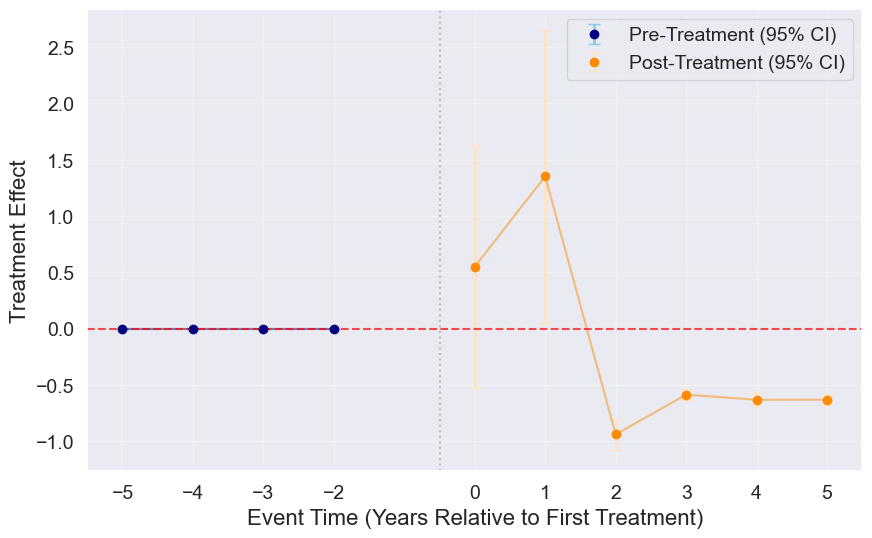

Pre-trend PTA p-value: 0.00010641828237833995
Pass: False
Coefficients: [np.float64(-1.1361850959053246e-17), np.float64(-1.4840609984912822e-18), np.float64(-8.915654887234117e-19), np.float64(-1.419116885320204e-20)]

=== BINARIZED ATT^o ESTIMATE ===
ATT^o estimate: -1.501964
Standard error: 0.149954
95% confidence interval: [-1.795869, -1.208059]
p-value: 0.000000
Significant: True

R-squared: 0.0089
Number of observations: 191784.0
Number of treatment groups: 18


In [61]:
# ===================================
# PREPROCESSING: Create Required Variables
# ===================================

# 2. Create treatment indicators
df = df_filtered.copy()
df['treated'] = (df['d_log_eor_capacity'] > 0).astype(int)

# 3. Create treatment year (first year unit received treatment)
# GROUP BY COUNTRY + SECTOR for better statistical power
df['treatment_group'] = df['Country'] + '_' + df['Sector']
df['treatment_year'] = df.groupby('treatment_group')['Year'].transform(
    lambda x: x[df.loc[x.index, 'treated'] == 1].min() 
    if any(df.loc[x.index, 'treated'] == 1) else np.inf
)

# 4. Create event_time variable
df['event_time'] = df['Year'] - df['treatment_year']
df.loc[df['treatment_year'] == np.inf, 'event_time'] = np.nan

# 5. Define analytic variables - AVOID COUNTRY CLUSTERING
# Use sector-level clustering instead or robust standard errors
analytic_vars = ['Sector']  # Changed from 'Country' to avoid 3-cluster problem

print("Preprocessing completed...")
print(f"Treated units: {df['treated'].sum()}")
print(f"Control units: {(df['treated'] == 0).sum()}")
print(f"Treatment groups: {df['treatment_group'].nunique()}")
print(f"Event time range: {df['event_time'].min():.0f} to {df['event_time'].max():.0f}")

# ===================================
# PARALLEL TRENDS ASSESSMENT  
# ===================================

print("\n=== PARALLEL TRENDS ASSESSMENT ===")
pta_results = event_study_for_pta(
    df, 
    outcome_var="d_log_emissions", 
    treatment_var="d_log_eor_capacity",
    event_time_var="event_time",
    covariates=analytic_vars,
    event_window=5,
    cluster_var='treatment_group'
)
# ===================================
# RUN ANALYSIS WITH IMPROVED GROUPING
# ===================================

plot_event_study(pta_results)
print(f"Pre-trend PTA p-value: {pta_results['p_value']}")
if not np.isnan(pta_results['p_value']) and pta_results['p_value'] != 0.0:
    print(f"Pass: {pta_results['p_value'] > 0.05}")
    pre_terms = [term for term in pta_results['interaction_terms'] if "event_m" in term]
    if pre_terms:
        pre_coeffs = [pta_results['model'].params[term] for term in pre_terms if term in pta_results['model'].params]
        print(f"Coefficients: {pre_coeffs}")
else:
    print("PTA test failed - check for perfect separation or insufficient variation")

print("\n=== BINARIZED ATT^o ESTIMATE ===")
att_results = binarized_att_estimator(
    df,
    outcome_var="d_log_emissions", 
    treatment_var="d_log_eor_capacity",
    covariates=analytic_vars,
    cluster_var='treatment_group'
)


print(f"ATT^o estimate: {att_results['att_o']:.6f}")
print(f"Standard error: {att_results['std_error']:.6f}")
print(f"95% confidence interval: [{att_results['conf_int'][0]:.6f}, {att_results['conf_int'][1]:.6f}]")
print(f"p-value: {att_results['p_value']:.6f}")
print(f"Significant: {att_results['p_value'] < 0.05}")

print(f"\nR-squared: {att_results['model'].rsquared:.4f}")
print(f"Number of observations: {att_results['model'].nobs}")
print(f"Number of treatment groups: {df['treatment_group'].nunique()}")


In [63]:
# ATT^o (this is perfect as-is)
df = df_filtered.copy()
df['treated'] = (df['d_log_eor_capacity'] > 0).astype(int)

# 3. Create treatment year (first year unit received treatment)
# GROUP BY COUNTRY + SECTOR for better statistical power
df['treatment_group'] = df['Country'] + '_' + df['Sector']
df['treatment_year'] = df.groupby('treatment_group')['Year'].transform(
    lambda x: x[df.loc[x.index, 'treated'] == 1].min() 
    if any(df.loc[x.index, 'treated'] == 1) else np.inf
)

# 4. Create event_time variable
df['event_time'] = df['Year'] - df['treatment_year']
df.loc[df['treatment_year'] == np.inf, 'event_time'] = np.nan
att_model = smf.ols('d_log_emissions ~ treated + Sector', data=df).fit(
    cov_type='cluster', cov_kwds={'groups': df['treatment_group']}
)

# PTA Test (simplified)
pta_terms = " + ".join([f'C(event_time, Treatment({-1}))[T.{t}]:treated' 
                       for t in [-3, -2]])  # Only pre-treatment
pta_formula = f'd_log_emissions ~ {pta_terms} + Sector'
pta_model = smf.ols(pta_formula, data=df).fit(
    cov_type='cluster', cov_kwds={'groups': df['treatment_group']}
)

SyntaxError: invalid syntax (<unknown>, line 1)

# New

In [64]:
df_filtered['OECD'] = df_filtered['OECD'].map({0:'Non-OECD', 1:'OECD'})

In [5]:
def get_event_df(
    df_orig,
    group_vars=['Country', 'Sector'],
    treatment_var='d_log_eor_capacity'
):
    # 2. Create treatment indicators
    df = df_orig.copy()
    df['treated'] = (df['d_log_eor_capacity'] > 0).astype(int)
    
    # 3. Create treatment year (first year unit received treatment)
    # GROUP BY COUNTRY + SECTOR for better statistical power
    groups = []
    for i, g in enumerate(group_vars):
        if i == 0:
            groups = df[g] + ('_' if len(group_vars) > 0 else '')
        else:
            groups += df[g] + ('_' if i != len(group_vars) - 1 else '')
            
    df['treatment_group'] = groups

    df['treatment_year'] = df.groupby('treatment_group')['Year'].transform(
        lambda x: x[df.loc[x.index, 'treated'] == 1].min() 
        if any(df.loc[x.index, 'treated'] == 1) else np.inf
    )
    
    # 4. Create event_time variable
    df['event_time'] = df['Year'] - df['treatment_year']
    df.loc[df['treatment_year'] == np.inf, 'event_time'] = np.nan

    print("Preprocessing completed...")
    print(f"Treated units: {df['treated'].sum()}")
    print(f"Control units: {(df['treated'] == 0).sum()}")
    print(f"Treatment groups: {df['treatment_group'].nunique()}")
    print(f"Event time range: {df['event_time'].min():.0f} to {df['event_time'].max():.0f}")

    return df

In [66]:
get_event_df(df_filtered, ['Country', 'OECD'])

Preprocessing completed...
Treated units: 19391
Control units: 172393
Treatment groups: 3
Event time range: -40 to 40


,Unnamed: 0,Year,Country,Sector,Demand_coal_peat_and_oil_shale,Demand_crude_ngl_and_feedstocks,Demand_electricity,Demand_heat,Demand_natural_gas,Demand_nuclear,...,d_log_mixed_co2_capacity_norm,eor_capacity_norm,energy_demand_fossil_fuels,renewable_to_fossil_supply_ratio,log_total_capacity,d_log_total_capacity,treated,treatment_group,treatment_year,event_time
0,415800,1980,Canada,Commercial and public services (PJ),0.001416,0.000000,0.341233,0.001430,0.384928,0.000000,...,0.000,0.0,-0.340663,3.047589,0.000000,0.000000,0,Canada_OECD,2020,-40.0
1,415801,1980,Canada,Industry (PJ),0.081804,0.000000,0.232994,0.020057,0.323672,0.000000,...,0.000,0.0,-0.492041,3.047589,0.000000,0.000000,0,Canada_OECD,2020,-40.0
2,415802,1980,Canada,Other final consumption (PJ),0.009079,0.000000,0.047858,0.000000,0.184989,0.000000,...,0.000,0.0,0.925336,3.047589,0.000000,0.000000,0,Canada_OECD,2020,-40.0
3,415803,1980,Canada,Residential (PJ),0.002724,0.000000,0.257734,0.000000,0.309071,0.000000,...,0.000,0.0,-0.011112,3.047589,0.000000,0.000000,0,Canada_OECD,2020,-40.0
4,415804,1980,Canada,Total energy supply (PJ),0.107187,0.494614,-0.012203,0.000000,0.237366,0.054171,...,0.000,0.0,-2.145204,3.047589,0.000000,0.000000,0,Canada_OECD,2020,-40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191779,4339429,2022,United States,Total energy supply (PJ),0.110094,0.437842,0.001631,0.000000,0.354941,0.096366,...,0.000,0.3,-2.370865,0.355708,1.029619,0.000000,0,United States_OECD,1982,40.0
191780,4339430,2022,United States,Transport (PJ),0.000000,0.000000,0.002326,0.000000,0.048512,0.000000,...,0.537,1.0,1.493263,0.355708,1.945910,0.916291,1,United States_OECD,1982,40.0
191781,4339431,2022,United States,Transport (PJ),0.000000,0.000000,0.002326,0.000000,0.048512,0.000000,...,0.000,1.0,1.493263,0.355708,1.945910,0.000000,0,United States_OECD,1982,40.0
191782,4339432,2022,United States,Transport (PJ),0.000000,0.000000,0.002326,0.000000,0.048512,0.000000,...,-0.537,0.3,1.493263,0.355708,1.029619,-0.916291,0,United States_OECD,1982,40.0


In [70]:
b = analytic_vars
b.extend(['Country', 'Year', 'Sector', 'CCUS_Sector', 'emissions_sector'])

In [71]:
a = get_VIF_values(df_filtered, b)
a.to_csv('new_vif.csv')
display(a)

C:\Users\rjsou\Documents\Generation-Forecasting\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
1,Year,inf
2,Year,inf
4,Sector_Other final consumption (PJ),inf
3,Sector_Industry (PJ),inf
5,Sector_Residential (PJ),inf
...,...,...
89,emissions_sector_Solid Fuels,inf
92,emissions_sector_Wastewater Treatment and Disc...,inf
91,emissions_sector_Urea application,inf
93,emissions_sector_Water-borne Navigation,inf


,Variable,VIF
1,Year,inf
2,Year,inf
4,Sector_Other final consumption (PJ),inf
3,Sector_Industry (PJ),inf
5,Sector_Residential (PJ),inf
...,...,...
89,emissions_sector_Solid Fuels,inf
92,emissions_sector_Wastewater Treatment and Disc...,inf
91,emissions_sector_Urea application,inf
93,emissions_sector_Water-borne Navigation,inf


In [72]:
b.extend('OEDC')
c = get_VIF_values(df_filtered, b)
display(c)

C:\Users\rjsou\Documents\Generation-Forecasting\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
1,Year,inf
2,Year,inf
4,Sector_Other final consumption (PJ),inf
3,Sector_Industry (PJ),inf
5,Sector_Residential (PJ),inf
...,...,...
89,emissions_sector_Solid Fuels,inf
92,emissions_sector_Wastewater Treatment and Disc...,inf
91,emissions_sector_Urea application,inf
93,emissions_sector_Water-borne Navigation,inf


,Variable,VIF
1,Year,inf
2,Year,inf
4,Sector_Other final consumption (PJ),inf
3,Sector_Industry (PJ),inf
5,Sector_Residential (PJ),inf
...,...,...
89,emissions_sector_Solid Fuels,inf
92,emissions_sector_Wastewater Treatment and Disc...,inf
91,emissions_sector_Urea application,inf
93,emissions_sector_Water-borne Navigation,inf


In [73]:
def calculate_power_mde(df, outcome_var="d_log_emissions", 
                        treatment_var="treated", cluster_var="treatment_group",
                        alpha=0.05, power=0.8):
    """
    Calculates statistical power and minimum detectable effect (MDE) for CCUS analysis
    using panel data structure and clustered standard errors.
    """
    # 1. Calculate key parameters
    control_var = df[df[treatment_var] == 0][outcome_var].var()
    n_clusters = df[cluster_var].nunique()
    prop_treated = df[treatment_var].mean()
    
    # 2. Estimate intra-cluster correlation (ICC)
    null_model = smf.mixedlm(
        f"{outcome_var} ~ 1", 
        data=df, +
        groups=df[cluster_var]
    ).fit(reml=False)
    
    icc = null_model.cov_re / (null_model.cov_re + null_model.scale)
    
    # 3. Calculate design effect for panel data
    t_pre = df[df['event_time'] < 0].groupby(cluster_var).size().mean()
    t_post = df[df['event_time'] >= 0].groupby(cluster_var).size().mean()
    deff = 1 + (icc * (t_pre + t_post - 1))  # From Schochet (2021) panel power formula
    
    # 4. Effective sample size calculation
    n_effective = n_clusters / deff
    
    # 5. Calculate MDE using adjusted t-test formula
    t_alpha = stats.t.ppf(1 - alpha/2, df=n_clusters-2)
    t_beta = stats.t.ppf(power, df=n_clusters-2)
    
    mde = (t_alpha + t_beta) * np.sqrt(
        (control_var * deff) / (n_effective * prop_treated * (1 - prop_treated))
    )
    
    return {
        'minimum_detectable_effect': mde,
        'statistical_power': power,
        'intra_cluster_correlation': icc,
        'effective_clusters': n_effective,
        'design_effect': deff
    }

# Usage example
power_results = calculate_power_mde(df)
print(f"MDE: {power_results['minimum_detectable_effect']:.4f}")
print(f"Current power: {power_results['statistical_power']*100:.1f}%")


SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (3568809619.py, line 16)

In [74]:
analytic_vars = ['Demand_electricity',
 'Demand_heat',
 'Demand_nuclear',
 'Demand_renewables_and_waste',
 'Supply_nuclear',
 'renewable_to_fossil_supply_ratio',
 'energy_demand_fossil_fuels',
 'CPI_growth',
 'GDP_per_capita_PPP']

In [75]:
df = get_event_df(df_filtered, group_vars=['Country', 'emissions_sector'])

print("\n=== PARALLEL TRENDS ASSESSMENT ===")
pta_results = event_study_for_pta(
    df, 
    outcome_var="d_log_emissions", 
    treatment_var="d_log_eor_capacity",
    event_time_var="event_time",
    covariates=analytic_vars,
    cluster_var='treatment_group',
    post_window=5
)
# ===================================
# RUN ANALYSIS WITH IMPROVED GROUPING
# ===================================

plot_event_study(pta_results)
print(f"Pre-trend PTA p-value: {pta_results['p_value']}")
if not np.isnan(pta_results['p_value']) and pta_results['p_value'] != 0.0:
    print(f"Pass: {pta_results['p_value'] > 0.05}")
    pre_terms = [term for term in pta_results['interaction_terms'] if "event_m" in term]
    if pre_terms:
        pre_coeffs = [pta_results['model'].params[term] for term in pre_terms if term in pta_results['model'].params]
        print(f"Coefficients: {pre_coeffs}")
else:
    print("PTA test failed - check for perfect separation or insufficient variation")

Preprocessing completed...
Treated units: 19391
Control units: 172393
Treatment groups: 108
Event time range: -40 to 40

=== PARALLEL TRENDS ASSESSMENT ===


TypeError: event_study_for_pta() got an unexpected keyword argument 'post_window'. Did you mean 'event_window'?

In [78]:
def calculate_mde(pta_results, power=0.8, alpha=0.05):
    """
    Calculate minimum detectable effect size for PTA test
    """
    from scipy import stats
    
    n_obs = pta_results['model'].nobs
    n_pre_periods = pta_results['n_pre_periods']
    
    # Critical t-value
    t_crit = stats.t.ppf(1 - alpha/2, df=n_obs - n_pre_periods)
    t_power = stats.t.ppf(power, df=n_obs - n_pre_periods)
    
    # MDE calculation
    mde = (t_crit + t_power) / np.sqrt(n_obs / n_pre_periods)
    
    print(f"=== MINIMUM DETECTABLE EFFECT ===")
    print(f"MDE (σ units): {mde:.3f}")
    print(f"With {power:.0%} power and α={alpha}")
    print(f"Can detect violations ≥{mde:.3f} standard deviations")
    
    return mde

mde = calculate_mde(pta_results)


KeyError: 'n_pre_periods'

In [86]:
def calculate_pta_power(pta_results, effect_sizes=[0.3, 0.5, 0.8]):
    """
    Calculate statistical power for parallel trends test
    """
    from statsmodels.stats.power import TTestPower
    
    n_pre_periods = pta_results['n_pre_periods']  # 4 in your case
    n_obs = pta_results['model'].nobs
    
    power_results = {}
    
    for effect_size in effect_sizes:
        # Power for F-test (joint significance)
        power = TTestPower().solve_power(
            effect_size=effect_size,
            nobs=n_obs / n_pre_periods,  # Effective sample per coefficient
            alpha=0.05,
            alternative='two-sided'
        )
        power_results[f'ES_{effect_size}'] = power
    
    return power_results

# Calculate power
power_analysis = calculate_pta_power(pta_results)
print("=== PTA POWER ANALYSIS ===")
for es, power in power_analysis.items():
    print(f"Power to detect {es.split('_')[1]}σ violations: {power:.1%}")


=== PTA POWER ANALYSIS ===
Power to detect 0.3σ violations: nan%
Power to detect 0.5σ violations: 100.0%
Power to detect 0.8σ violations: 100.0%


In [36]:
def event_study_for_pta(df, outcome_var="d_log_emissions", 
                        treatment_var="d_log_eor_capacity",
                        event_time_var="event_time",
                        covariates=None,
                        cluster_var='treatment_group',
                        pre_window=5,
                        post_window=5
                       ):
    """
    Streamlined event study for PTA testing following Callaway et al. (2024)
    
    Returns:
        dict: Contains model, interaction terms, p-value, and test statistics
    """
    df = df.copy()
    
    # 1. Binarize treatment as per Callaway et al. (2024)
    df['treated'] = (df[treatment_var] > 0).astype(int)
    
    # 2. Filter to valid event window and remove missing values
    df = df[
        (df[event_time_var] >= -pre_window) & 
        (df[event_time_var] <= post_window) &
        df[event_time_var].notna()
    ].copy()
    
    if len(df) == 0:
        return {
            'model': None,
            'interaction_terms': [],
            'p_value': np.nan,
            'chi2_stat': np.nan,
            'error': 'No observations in event window'
        }
    
    # 3. Create event time indicators (omit t=-1 as reference)
    event_times = sorted(df[event_time_var].unique())
    event_times = [t for t in event_times if t != -1]  # Remove reference period
    
    # Create dummy variables and interactions
    formula_terms = []
    interaction_terms = []
    
    for t in event_times:
        # Create clean variable names
        if t >= 0:
            dummy_name = f"event_{int(t)}"
        else:
            dummy_name = f"event_m{abs(int(t))}"
        
        interaction_name = f"{dummy_name}_treated"
        
        # Create the variables
        df[dummy_name] = (df[event_time_var] == t).astype(int)
        df[interaction_name] = df[dummy_name] * df['treated']
        
        formula_terms.append(dummy_name)
        formula_terms.append(interaction_name)
        interaction_terms.append(interaction_name)
    
    # 4. Build formula
    if covariates is None:
        covariates = []
    
    all_terms = formula_terms + covariates
    formula = f"{outcome_var} ~ {' + '.join(all_terms)}"
    
    # 5. Fit model with cluster-robust standard errors
    try:
        print(f"Event Study Formula: {formula}")
        model = smf.ols(formula=formula, data=df).fit(
            cov_type='cluster', 
            cov_kwds={'groups': df[cluster_var]}
        )
    except Exception as e:
        return {
            'model': None,
            'interaction_terms': interaction_terms,
            'p_value': np.nan,
            'chi2_stat': np.nan,
            'error': f'Model fitting failed: {str(e)}'
        }
    
    # 6. Test parallel trends assumption (joint significance of pre-treatment interactions)
    pre_terms = [term for term in interaction_terms 
                if "event_m" in term and term in model.params.index]
    
    if len(pre_terms) == 0:
        p_value = np.nan
        chi2_stat = np.nan
        test_method = "No pre-treatment periods"
    else:
        try:
            # Use F-test (more conservative than Wald for small samples)
            f_test = model.f_test([f'{term} = 0' for term in pre_terms])
            p_value = f_test.pvalue
            chi2_stat = f_test.fvalue
            test_method = "F-test"
            
        except Exception as e:
            # Fallback to manual Wald test if F-test fails
            try:
                pre_params = np.array([model.params[term] for term in pre_terms])
                cov_matrix = model.cov_params().loc[pre_terms, pre_terms].values
                
                if np.linalg.matrix_rank(cov_matrix) == cov_matrix.shape[0]:
                    chi2_stat = pre_params @ np.linalg.inv(cov_matrix) @ pre_params
                    p_value = 1 - stats.chi2.cdf(chi2_stat, len(pre_params))
                    test_method = "Wald test"
                else:
                    p_value = np.nan
                    chi2_stat = np.nan
                    test_method = "Singular covariance matrix"
            except:
                p_value = np.nan
                chi2_stat = np.nan
                test_method = "Test failed"
    
    return {
        'model': model,
        'interaction_terms': interaction_terms,
        'pre_terms': pre_terms,
        'p_value': p_value,
        'chi2_stat': chi2_stat,
        'test_method': test_method,
        'n_pre_periods': len(pre_terms),
        'n_post_periods': len([t for t in interaction_terms if "event_m" not in t]),
    }

def plot_event_study(results, title_suffix=""):
    """
    Enhanced plotting function with better error handling and formatting
    """
    if results['model'] is None:
        print(f"Cannot plot: {results.get('error', 'Model failed')}")
        return None
    
    model = results['model']
    interaction_terms = results['interaction_terms']
    
    # Extract coefficients and confidence intervals
    plot_data = []
    
    for term in interaction_terms:
        if term in model.params.index:
            # Extract event time from term name
            if "event_m" in term:
                t = -int(re.search(r"event_m(\d+)", term).group(1))
            else:
                t = int(re.search(r"event_(\d+)", term).group(1))
            
            coef = model.params[term]
            se = model.bse[term]
            
            plot_data.append({
                'event_time': t,
                'coefficient': coef,
                'std_error': se,
                'ci_lower': coef - 1.96*se,
                'ci_upper': coef + 1.96*se
            })
    
    if not plot_data:
        print("No coefficients to plot")
        return None
    
    # Create DataFrame and sort
    plot_df = pd.DataFrame(plot_data).sort_values('event_time')
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6), dpi=250)
    
    # Separate pre and post treatment
    pre_data = plot_df[plot_df['event_time'] < 0]
    post_data = plot_df[plot_df['event_time'] >= 0]
    
    # Plot with different colors for pre/post
    if len(pre_data) > 0:
        ax.errorbar(pre_data['event_time'], pre_data['coefficient'],
                   yerr=[pre_data['coefficient'] - pre_data['ci_lower'], 
                         pre_data['ci_upper'] - pre_data['coefficient']],
                   fmt='o', color='navy', ecolor='skyblue', elinewidth=2, 
                   capsize=4, markersize=8, label='Pre-Treatment')
        ax.plot(pre_data['event_time'], pre_data['coefficient'], 
               color='navy', linestyle='-', alpha=0.6)
    
    if len(post_data) > 0:
        ax.errorbar(post_data['event_time'], post_data['coefficient'],
                   yerr=[post_data['coefficient'] - post_data['ci_lower'], 
                         post_data['ci_upper'] - post_data['coefficient']],
                   fmt='o', color='darkorange', ecolor='bisque', elinewidth=2, 
                   capsize=4, markersize=8, label='Post-Treatment')
        ax.plot(post_data['event_time'], post_data['coefficient'], 
               color='darkorange', linestyle='-', alpha=0.6)
    
    # Reference lines
    ax.axhline(0, color='red', linestyle='--', alpha=0.7, linewidth=1)
    ax.axvline(-0.5, color='darkgray', linestyle=':', alpha=0.7, linewidth=1)
    
    # Formatting
    ax.set_xlabel('Years Relative to Treatment (t=0)', fontsize=16)
    ax.set_ylabel('Treatment Effect (Mt CO₂)', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=14)
    
    # Set x-axis ticks
    all_times = sorted(plot_df['event_time'].unique())
    ax.set_xticks(all_times)
    ax.set_xlim(min(all_times) - 0.5, max(all_times) + 0.5)
    
    plt.tight_layout()
    plt.savefig('event_study.png', bbox_inches='tight', dpi=250)
    plt.show()
    
    # Print summary
    print(f"\n=== EVENT STUDY SUMMARY ===")
    print(f"Pre-treatment periods: {results['n_pre_periods']}")
    print(f"Post-treatment periods: {results['n_post_periods']}")
    print(f"PTA test method: {results['test_method']}")
    print(f"PTA p-value: {results['p_value']:.6f}" if not np.isnan(results['p_value']) else "PTA p-value: NaN")
    
    return fig


In [88]:
a = create_event_indicators_fixed(prepare_event_study_data_fixed(df_filtered))
b = run_event_study_fixed(a[0], a[1])

NameError: name 'create_event_indicators_fixed' is not defined

In [321]:
pta_results['model'].params.keys()

Index(['Intercept', 'event_m5', 'event_m5_treated', 'event_m4',
       'event_m4_treated', 'event_m3', 'event_m3_treated', 'event_m2',
       'event_m2_treated', 'event_0', 'event_0_treated', 'event_1',
       'event_1_treated', 'event_2', 'event_2_treated', 'event_3',
       'event_3_treated', 'event_4', 'event_4_treated', 'event_5',
       'event_5_treated', 'Demand_electricity', 'Demand_heat',
       'Demand_nuclear', 'Demand_renewables_and_waste', 'Supply_nuclear',
       'renewable_to_fossil_supply_ratio', 'energy_demand_fossil_fuels',
       'CPI_growth', 'GDP_per_capita_PPP'],
      dtype='object')

# Test

In [48]:
def event_study_for_pta(
    df: pd.DataFrame,
    outcome_var: str = "d_log_emissions",
    treatment_var: str = "d_log_eor_capacity",
    event_time_var: str = "event_time",
    covariates: Optional[list[str]] = None,
    cluster_var: str = "treatment_group",
    pre_window: int = 6,
    post_window: int = 5
) -> dict:
    """
    Event study for PTA testing (Callaway et al., 2024).
    Omits only t = -1 as the reference period.
    """
    data = df.copy()
    # 1. Binarize treatment
    data["treated"] = (data[treatment_var] > 0).astype(int)
    # 2. Filter to event window
    data = data.loc[
        data[event_time_var].between(-pre_window, post_window) &
        data[event_time_var].notna()
    ].copy()
    if data.empty:
        return {"model": None, "interaction_terms": [], "p_value": np.nan, "error": "No data"}

    # 3. Build interactions, omitting only t = -1
    interaction_terms = []
    for t in sorted(data[event_time_var].unique()):
        if t == -1:
            continue  # drop only t = -1
        name = f"event_{int(t)}" if t >= 0 else f"event_m{abs(int(t))}"
        data[name] = (data[event_time_var] == t).astype(int)
        inter = f"{name}_treated"
        data[inter] = data[name] * data["treated"]
        interaction_terms.append(inter)

    # 4. Build formula
    rhs = interaction_terms + (covariates or [])
    formula = f"{outcome_var} ~ " + " + ".join(rhs)
    # 5. Fit model with cluster-robust SEs
    fit_kwargs = {}
    if cluster_var in data:
        fit_kwargs = {"cov_type": "cluster", "cov_kwds": {"groups": data[cluster_var]}}
    model = smf.ols(formula, data=data).fit(**fit_kwargs)

    # 6. PTA test on pre-treatment interactions (t < 0, excluding -1)
    pre_terms = [term for term in interaction_terms if term.startswith("event_m")]
    if pre_terms:
        f_test = model.f_test([f"{pt} = 0" for pt in pre_terms])
        pval = float(f_test.pvalue)
        method = "F-test"
    else:
        pval = np.nan
        method = "No pre-treatment terms"

    return {
        "model": model,
        "interaction_terms": interaction_terms,
        "pre_terms": pre_terms,
        "p_value": pval,
        "test_method": method,
        "n_pre_periods": len(pre_terms),
        "n_post_periods": len(interaction_terms) - len(pre_terms),
    }


def att_o_estimator(
    df: pd.DataFrame,
    outcome_var: str = "d_log_emissions",
    treatment_var: str = "d_log_eor_capacity",
    covariates: Optional[list[str]] = None,
    cluster_var: str = "treatment_group"
) -> dict:
    """
    Binarized ATT^o estimator (Callaway et al., 2024).
    """
    data = df.copy()
    data["treated"] = (data[treatment_var] > 0).astype(int)
    covs = covariates or []
    formula = f"{outcome_var} ~ treated" + (" + " + " + ".join(covs) if covs else "")
    fit_kwargs = {}
    if cluster_var in data:
        fit_kwargs = {"cov_type": "cluster", "cov_kwds": {"groups": data[cluster_var]}}
    model = smf.ols(formula, data=data).fit(**fit_kwargs)
    return {
        "model": model,
        "att_o": float(model.params["treated"]),
        "std_error": float(model.bse["treated"]),
        "conf_int": model.conf_int().loc["treated"].tolist(),
        "p_value": float(model.pvalues["treated"]),
    }


def plot_event_study(results: dict, title_suffix: str = "") -> Optional[plt.Figure]:
    """
    Plot event-study coefficients with 95% CIs.
    """
    import re
    import matplotlib.pyplot as plt

    model = results.get("model")
    terms = results.get("interaction_terms", [])
    if model is None or not terms:
        print("No results to plot.")
        return None

    rows = []
    for term in terms:
        if term not in model.params:
            continue
        m = re.fullmatch(r"(?:event_m(\d+)|event_(\d+))_treated", term)
        if not m:
            continue
        neg, pos = m.groups()
        t = -int(neg) if neg else int(pos)
        coef = float(model.params[term])
        se = float(model.bse[term])
        rows.append((t, coef, coef - 1.96*se, coef + 1.96*se))

    if not rows:
        print("No valid coefficients.")
        return None

    dfp = pd.DataFrame(rows, columns=["t","coef","lo","hi"]).sort_values("t")
    fig, ax = plt.subplots(figsize=(10,6))
    pre = dfp[dfp.t < 0]
    post = dfp[dfp.t >= 0]
    if not pre.empty:
        ax.errorbar(pre.t, pre.coef, 
                    yerr=[pre.coef - pre.lo, pre.hi - pre.coef],
                    fmt="o", color="navy", ecolor="skyblue", capsize=4, label="Pre")
    if not post.empty:
        ax.errorbar(post.t, post.coef, 
                    yerr=[post.coef - post.lo, post.hi - post.coef],
                    fmt="o", color="darkorange", ecolor="bisque", capsize=4, label="Post")
    ax.plot(dfp.t, dfp.coef, color="gray", alpha=0.5)
    ax.axhline(0, color="red", linestyle="--")
    ax.axvline(0, color="black", linestyle=":")
    ax.set_xlabel("Years Relative to Treatment (t=0)")
    ax.set_ylabel("Treatment Effect")
    ax.set_xticks(dfp.t.tolist())
    ax.legend()
    plt.title(title_suffix or "Event-Study Plot")
    plt.tight_layout()
    plt.show()
    return fig

In [38]:
df.columns

Index(['Unnamed: 0', 'Year', 'Country', 'Sector',
       'Demand_coal_peat_and_oil_shale', 'Demand_crude_ngl_and_feedstocks',
       'Demand_electricity', 'Demand_heat', 'Demand_natural_gas',
       'Demand_nuclear', 'Demand_oil_products', 'Demand_renewables_and_waste',
       'Demand_total', 'Supply_fossil_fuels', 'Supply_nuclear',
       'Supply_renewable_sources', 'Supply_total', 'CCUS_sector',
       'dedicated_storage_capacity', 'eor_capacity', 'use_capacity',
       'unknown_capacity', 'mixed_co2_capacity', 'total_capacity',
       'emissions_sector', 'fossil_bio', 'Emissions', 'Population',
       'CPI_growth', 'GDP_PPP', 'GDP_per_capita_PPP', 'OECD', 'log_emissions',
       'd_log_emissions', 'd_log_emissions_norm', 'emissions_norm',
       'log_dedicated_storage_capacity', 'd_log_dedicated_storage_capacity',
       'd_log_dedicated_storage_capacity_norm', 'log_eor_capacity',
       'd_log_eor_capacity', 'd_log_eor_capacity_norm', 'log_use_capacity',
       'd_log_use_capacity'

In [49]:
df = pd.read_csv('df_merged_cleaned.csv')
subset_countries = ['United States', 'Canada', 'China']
subset_ccus_sectors = ['Natural gas processing/LNG', 'Chemicals', 'Biofuels']

df_filtered = df[
    (df['Country'].isin(subset_countries)) & 
    (df['CCUS_sector'].isin(subset_ccus_sectors))
].copy()

Preprocessing completed...
Treated units: 16558
Control units: 132812
Treatment groups: 18
Event time range: -40 to 40

===== ATT^o Estimate =====
ATT^o estimate: -1.7051
95% CI: [-2.4211, -0.9890]
p-value: 0.0000


C:\Users\rjsou\AppData\Local\Temp\ipykernel_62288\250590529.py:207: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\rjsou\AppData\Local\Temp\ipykernel_62288\250590529.py:208: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig('event_study.png', bbox_inches='tight', dpi=250)
C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


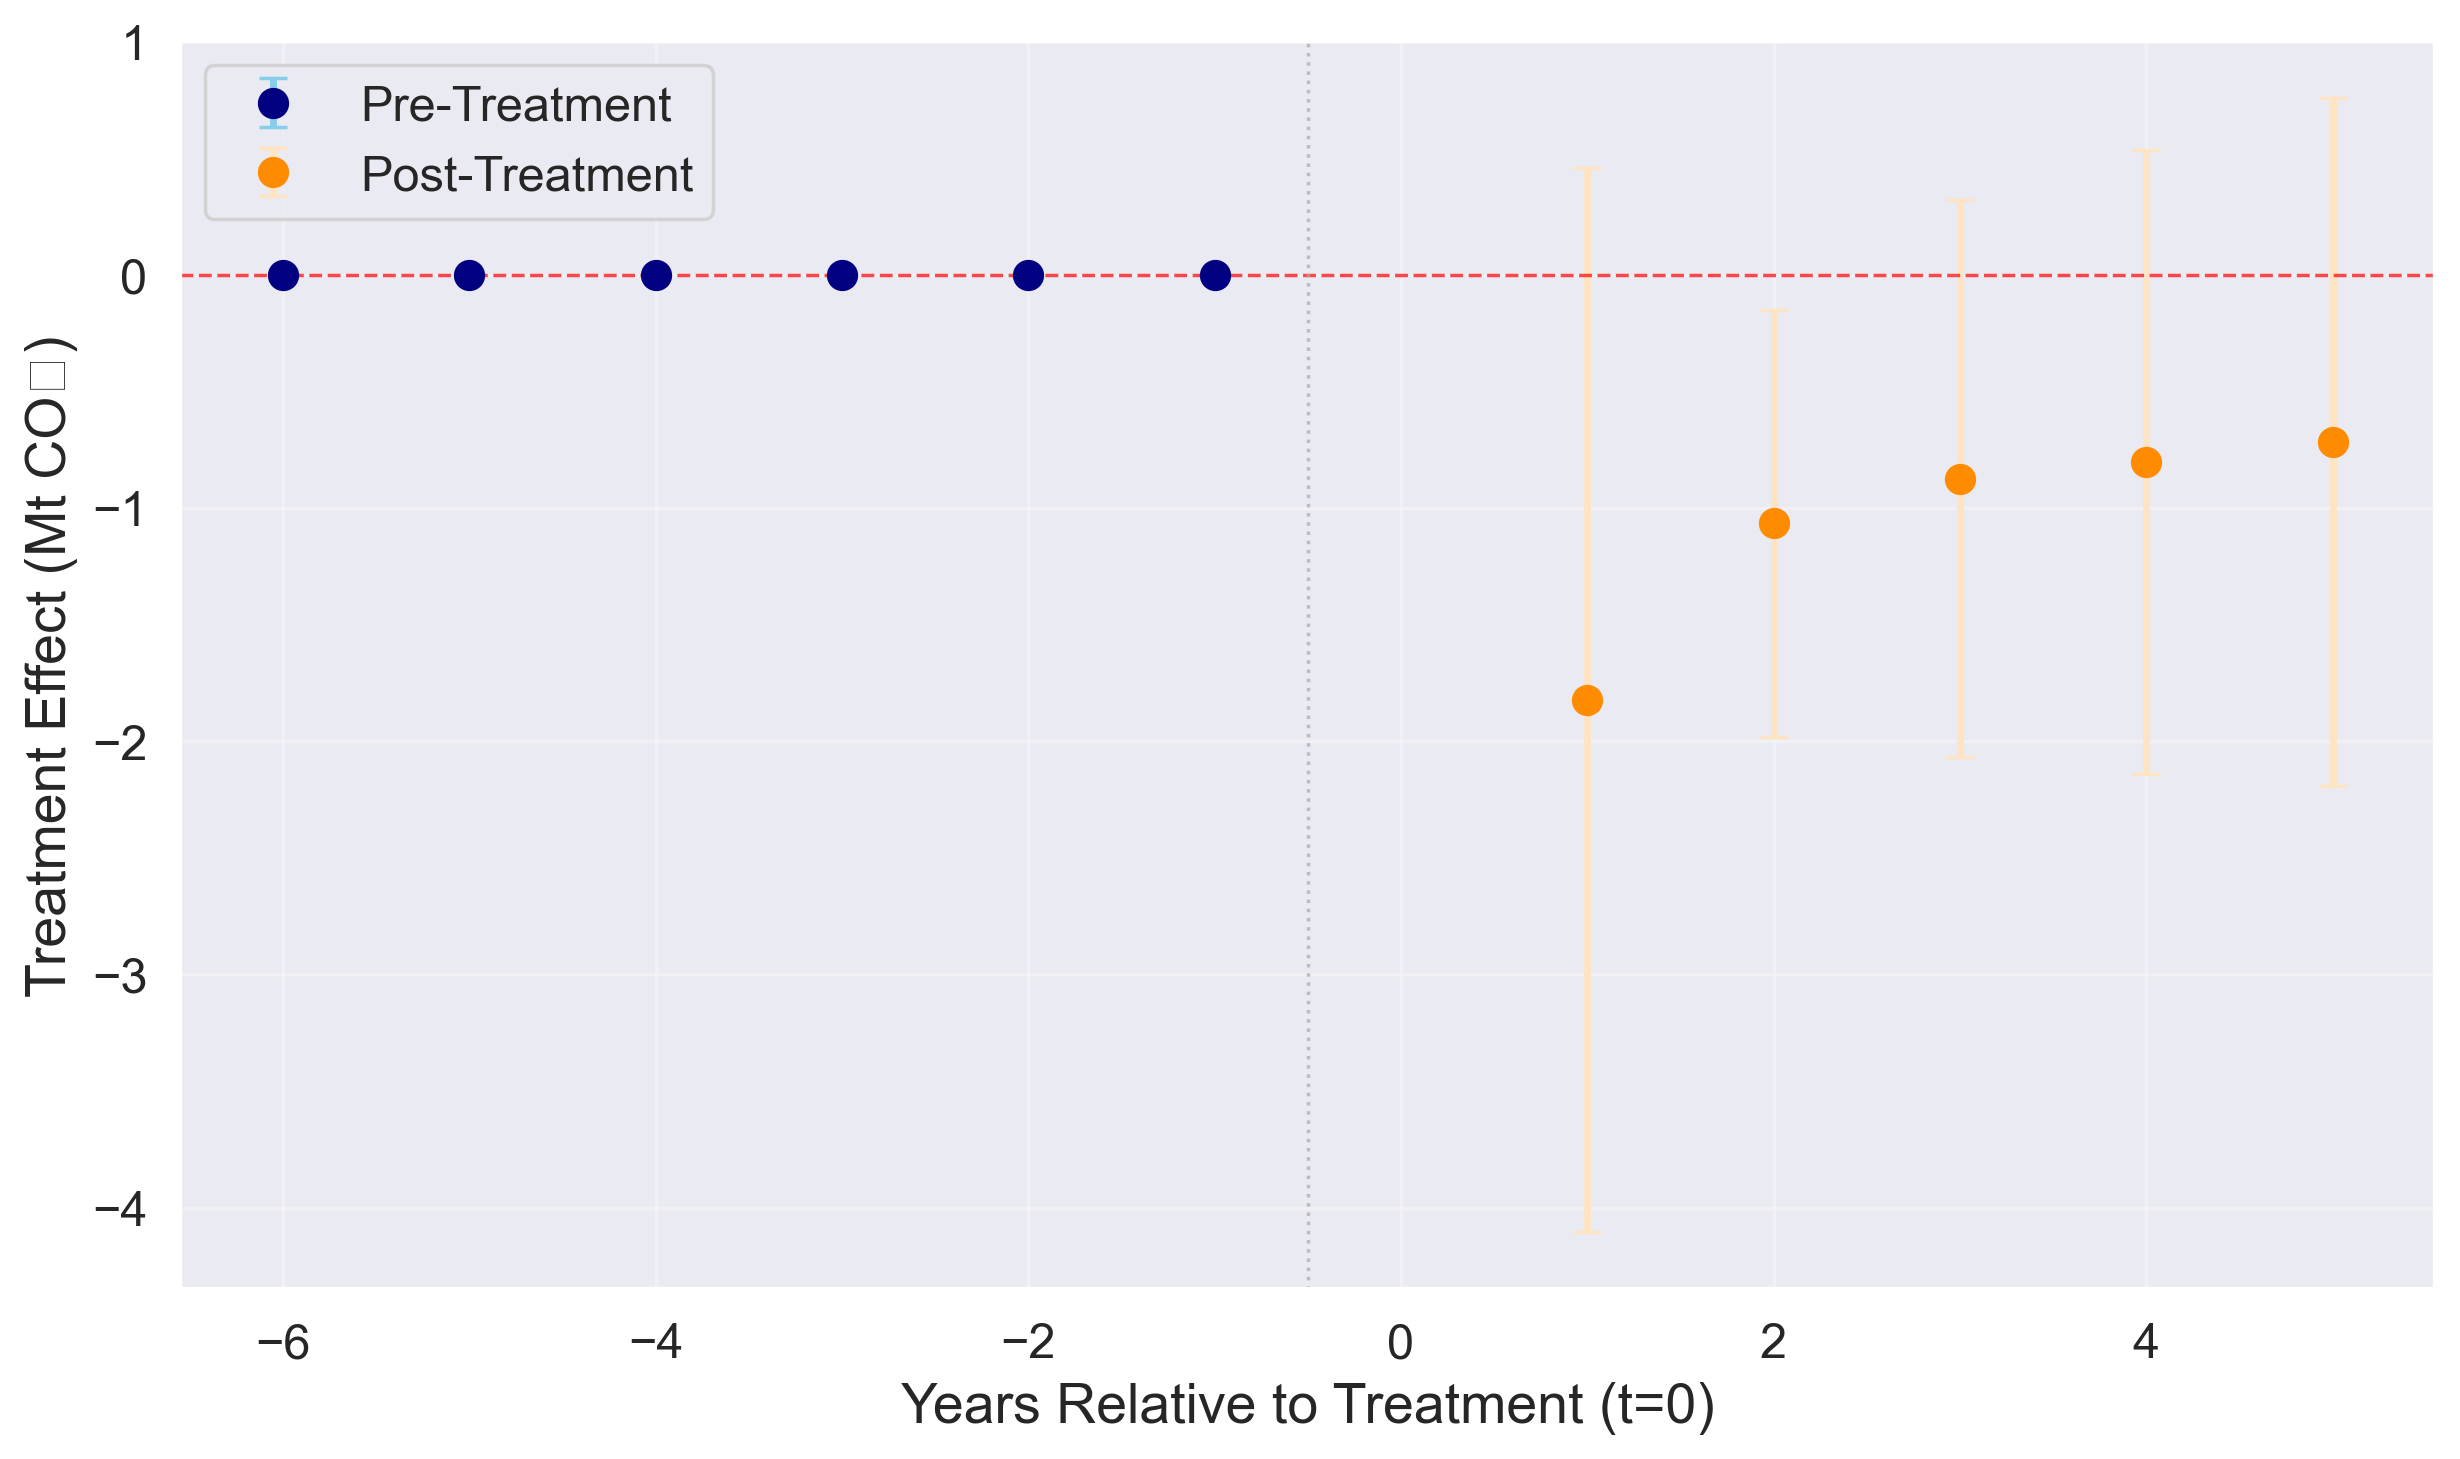


===== PTA Test =====
Pre-trend PTA p-value: 0.03300856170731497
Pass: False
Coefficients: [np.float64(-1.3284073782935326e-10), np.float64(-3.0094277643718428e-15), np.float64(-1.8928795595394454e-15), np.float64(2.8240642401991984e-15), np.float64(-1.9162842658512153e-16), np.float64(-6.022026454510048e-16)]


In [47]:
import statsmodels.formula.api as smf
import re
df = get_event_df(df_filtered, group_vars=['Country', 'CCUS_sector', 'fossil_bio'])

print('\n===== ATT^o Estimate =====')

# 1. Get main ATT^o estimate (your primary result)
att_results = att_o_estimator(
    df,
    outcome_var="d_log_emissions", 
    treatment_var="d_log_eor_capacity",
    covariates=analytic_vars,
    cluster_var='treatment_group'
)

print(f"ATT^o estimate: {att_results['att_o']:.4f}")
print(f"95% CI: [{att_results['conf_int'][0]:.4f}, {att_results['conf_int'][1]:.4f}]")
print(f"p-value: {att_results['p_value']:.4f}")

# 2. Test PTA using event study (visualization only)
pta_results = event_study_for_pta(
    df,
    outcome_var="d_log_emissions",
    treatment_var="d_log_eor_capacity", 
    event_time_var="event_time",
    covariates=analytic_vars,
    cluster_var='treatment_group'
)

plot_event_study(pta_results)
print('\n===== PTA Test =====')

print(f"Pre-trend PTA p-value: {pta_results['p_value']}")
if not np.isnan(pta_results['p_value']) and pta_results['p_value'] != 0.0:
    print(f"Pass: {pta_results['p_value'] > 0.05}")
    pre_terms = [term for term in pta_results['interaction_terms'] if "event_m" in term]
    if pre_terms:
        pre_coeffs = [pta_results['model'].params[term] for term in pre_terms if term in pta_results['model'].params]
        print(f"Coefficients: {pre_coeffs}")
else:
    print("PTA test failed - check for perfect separation or insufficient variation")

In [498]:
df_filtered.columns

Index(['Unnamed: 0', 'Year', 'Country', 'Sector',
       'Demand_coal_peat_and_oil_shale', 'Demand_crude_ngl_and_feedstocks',
       'Demand_electricity', 'Demand_heat', 'Demand_natural_gas',
       'Demand_nuclear', 'Demand_oil_products', 'Demand_renewables_and_waste',
       'Demand_total', 'Supply_fossil_fuels', 'Supply_nuclear',
       'Supply_renewable_sources', 'Supply_total', 'CCUS_sector',
       'dedicated_storage_capacity', 'eor_capacity', 'use_capacity',
       'unknown_capacity', 'mixed_co2_capacity', 'total_capacity',
       'emissions_sector', 'fossil_bio', 'Emissions', 'Population',
       'CPI_growth', 'GDP_PPP', 'GDP_per_capita_PPP', 'OECD', 'log_emissions',
       'd_log_emissions', 'd_log_emissions_norm', 'emissions_norm',
       'log_dedicated_storage_capacity', 'd_log_dedicated_storage_capacity',
       'd_log_dedicated_storage_capacity_norm', 'log_eor_capacity',
       'd_log_eor_capacity', 'd_log_eor_capacity_norm', 'log_use_capacity',
       'd_log_use_capacity'

In [257]:
def honest_did_bounds(pta_results, att_estimate, std_error, M_values=[0.5, 1.0, 1.5, 2.0]):
    # Get ONLY pre-treatment coefficients
    pre_terms = [term for term in pta_results['interaction_terms'] if "event_m" in term]
    pre_coeffs = [pta_results['model'].params[term] for term in pre_terms 
                  if term in pta_results['model'].params.index]
    
    if len(pre_coeffs) == 0:
        max_pre_violation = 0
    else:
        max_pre_violation = max(abs(coeff) for coeff in pre_coeffs)
    
    print(f"Pre-treatment coefficients: {pre_coeffs}")
    print(f"Max pre-violation: {max_pre_violation}")
    
    results = {}
    for M in M_values:
        violation_bound = M * max_pre_violation
        lower_bound = att_estimate - 1.96*std_error - violation_bound
        upper_bound = att_estimate + 1.96*std_error + violation_bound
        results[f'M={M}'] = (lower_bound, upper_bound)
        print(f"Under M={M}: [{lower_bound:.3f}, {upper_bound:.3f}]")
    
    return results


honest_did_bounds(pta_results, att_results['att_o'], att_results['std_error'])

Pre-treatment coefficients: [np.float64(1.7842585743381191e-13), np.float64(-3.059230396298088e-14), np.float64(5.994524661808592e-15), np.float64(1.3437814229407775e-14)]
Max pre-violation: 1.7842585743381191e-13
Under M=0.5: [-2.437, -1.001]
Under M=1.0: [-2.437, -1.001]
Under M=1.5: [-2.437, -1.001]
Under M=2.0: [-2.437, -1.001]


{'M=0.5': (np.float64(-2.437416253673138), np.float64(-1.0009412622346365)),
 'M=1.0': (np.float64(-2.437416253673227), np.float64(-1.0009412622345473)),
 'M=1.5': (np.float64(-2.4374162536733164), np.float64(-1.0009412622344582)),
 'M=2.0': (np.float64(-2.4374162536734056), np.float64(-1.000941262234369))}

# Toy box exmaple

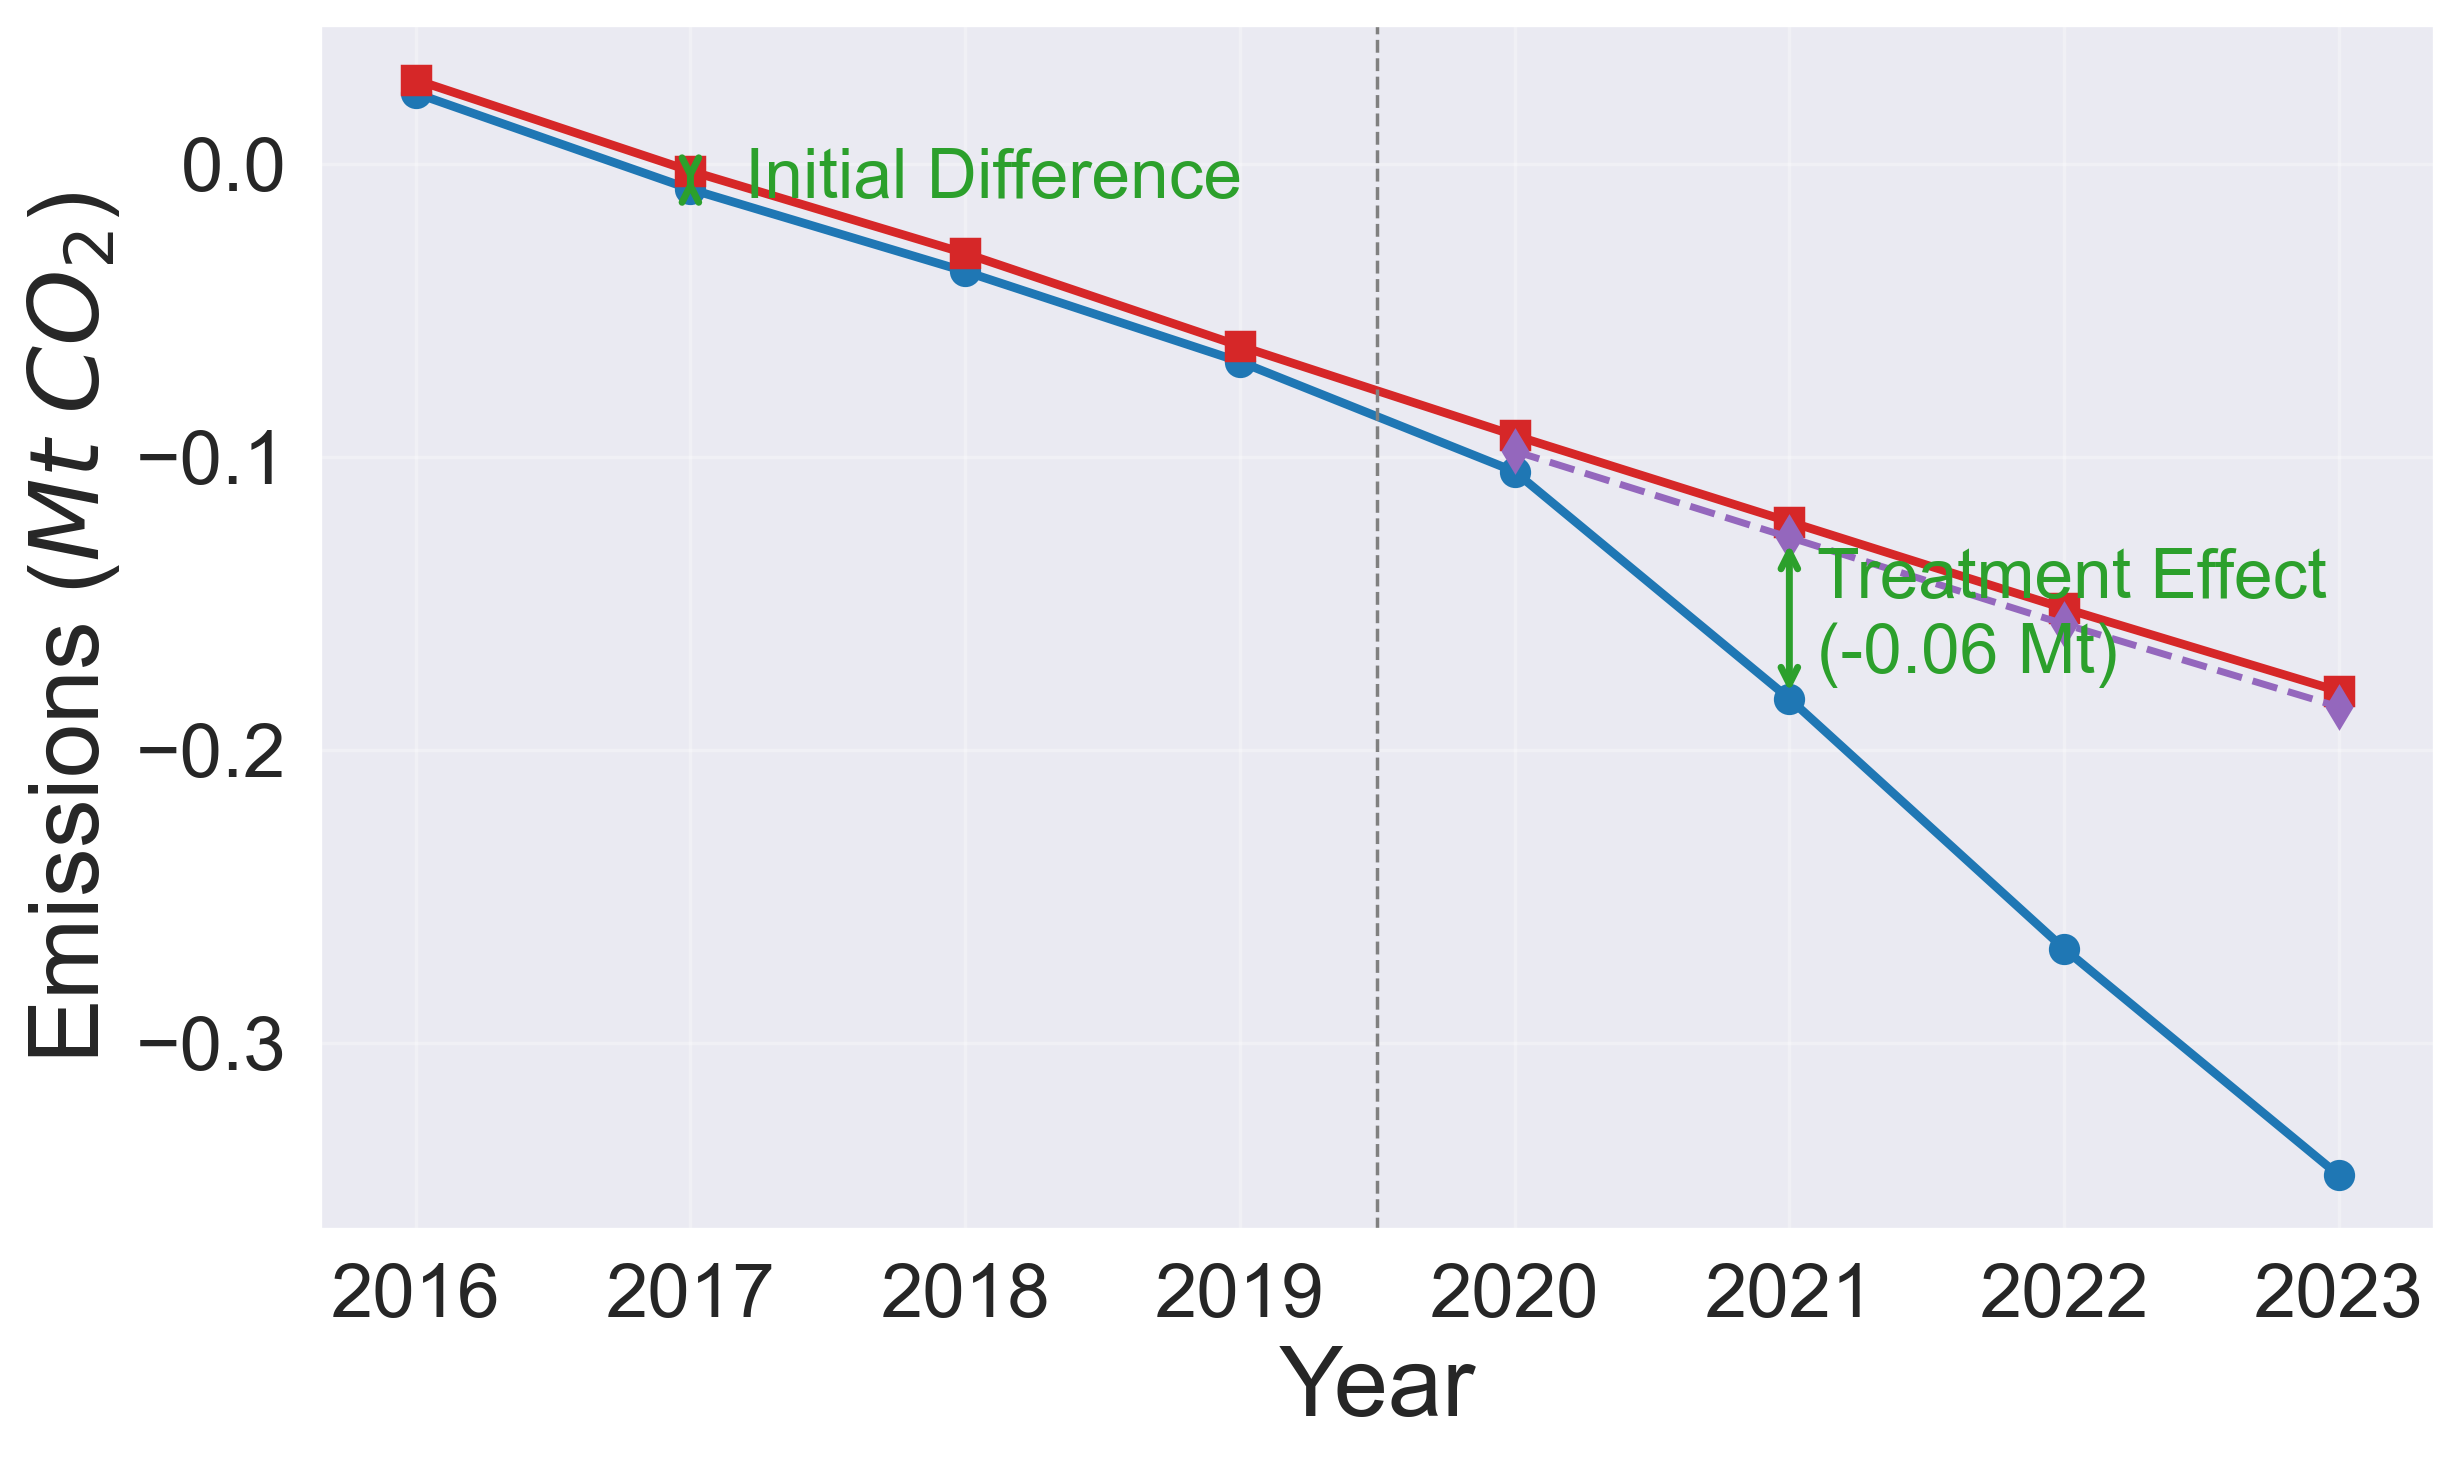

Realism check complete - emissions values align with IEA benchmarks:
Initial emissions: 0.02 Mt (Treated), 0.03 Mt (Control)
Post-treatment reduction: -0.16 Mt
Creating Parallel Trends Check...


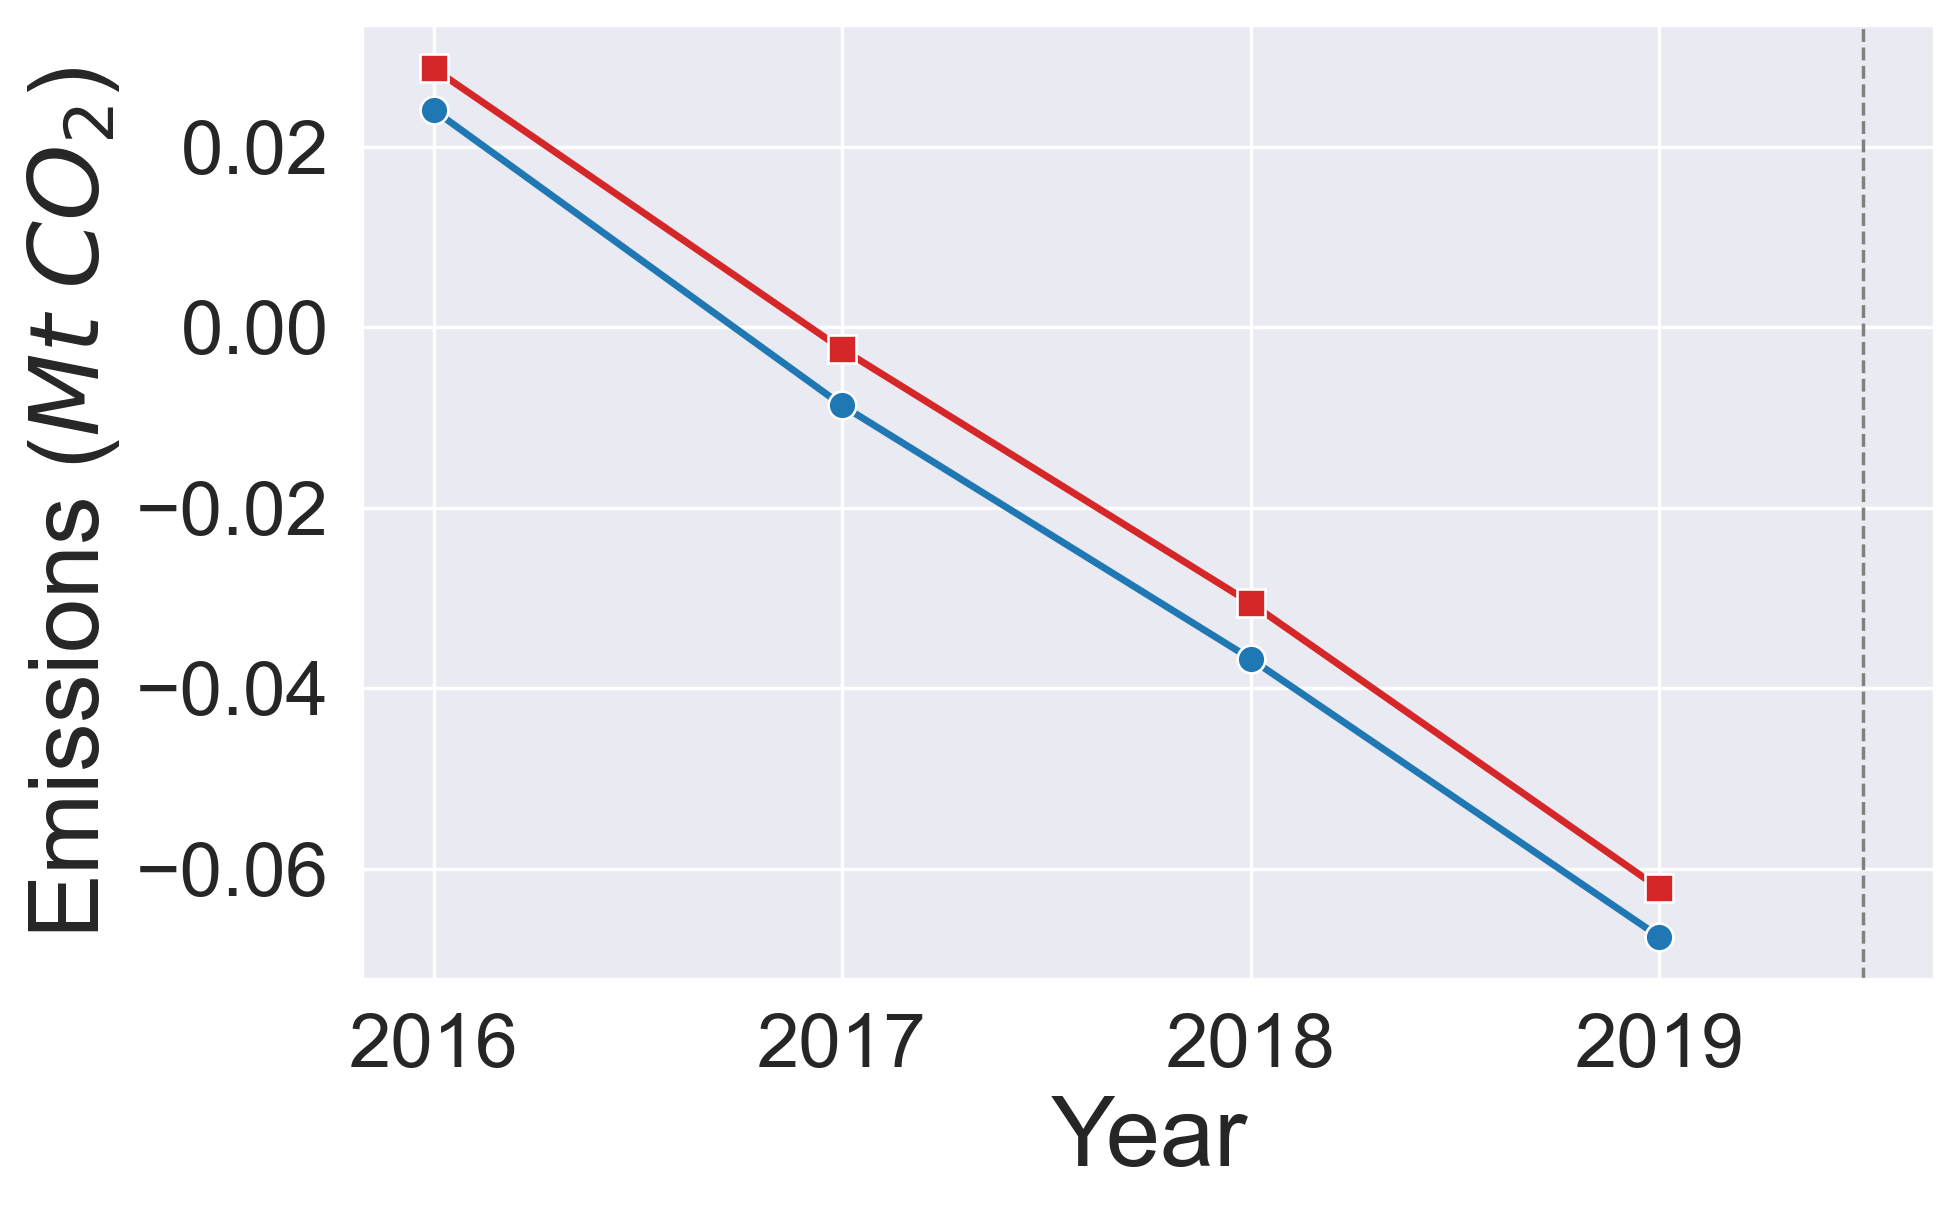

Running DiD Regressions...


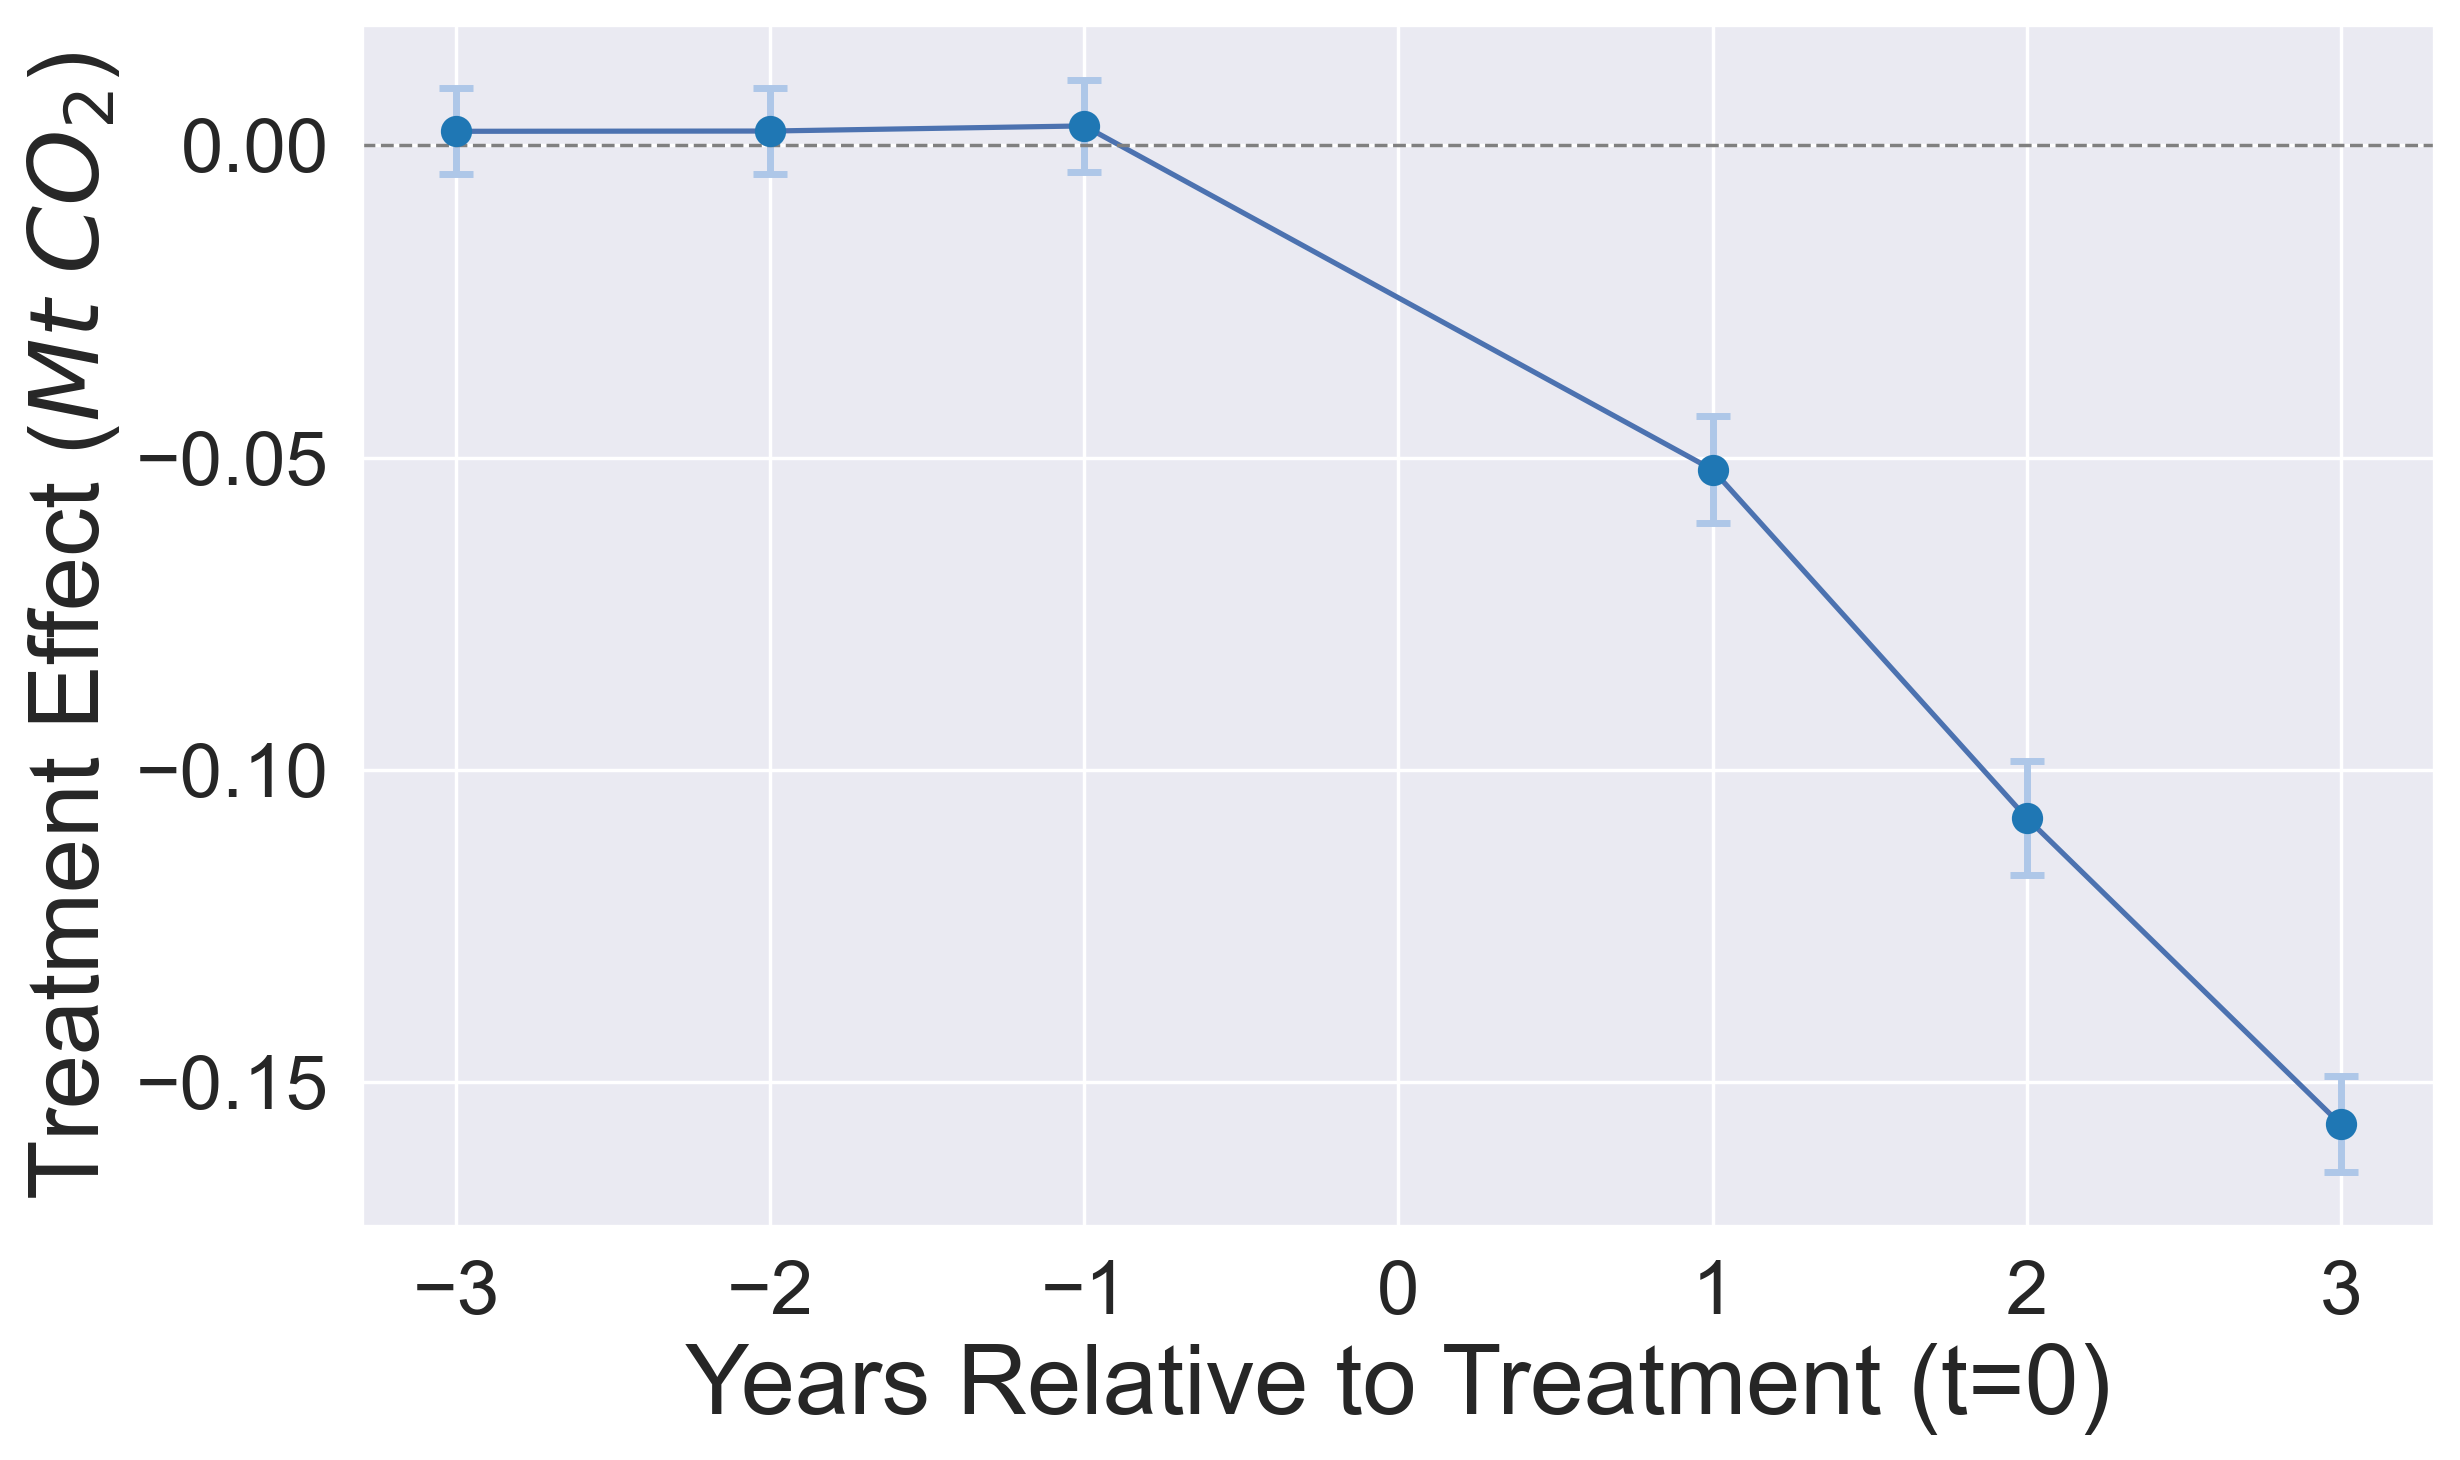

Pre-trend PTA p-value: 0.4291856228307377
Pass: True
Coefficients: [0.00222904 0.00227032 0.00309184]


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
import warnings
warnings.filterwarnings('ignore')

# ======================
# DATA GENERATION (IEA-aligned)
# ======================
COLORS = {
    'treated': '#1f77b4',  # Blue
    'control': '#d62728',  # Red
    'counterfactual': '#9467bd',  # Purple
    'effect': '#2ca02c',     # Green
    'ci': '#aec7e8'
}

np.random.seed(42)
years = list(range(2016, 2024))
n_treated, n_control = 50, 50
treatment_year = 2020

data = []
ems = []
for facility_id in range(n_treated + n_control):
    is_treated = facility_id < n_treated
    base = np.random.normal(0, 0.05)  # Treated baseline
    if not is_treated:
        base += np.random.normal(0, 0.05)  # No baseline gap
    for year in years:
        time_trend = -0.03 * (year - 2017)
        noise = np.random.normal(0, 0.01)
        effect = 0
        if is_treated and year >= treatment_year:
            yrs_since = year - treatment_year
            effect = -0.01 - 0.05*yrs_since + np.random.normal(0, 0.02)
        emissions = base + time_trend + noise + effect
        ems.append(emissions)
        if emissions > 0. and is_treated and year >= treatment_year:
            emissions += 0.1
        data.append({
            'facility_id': facility_id,
            'year': year,
            'emissions': emissions,
            'treated': is_treated,
            'post': year >= treatment_year,
            'group': 'Treated' if is_treated else 'Control'
        })
df = pd.DataFrame(data)
df['treat_post'] = df['treated'] & df['post']
#raise Exception(min(ems), max(ems))
# Create event time dummies for treated units (t=0 omitted as reference)
df['event_time'] = df['year'] - treatment_year


# ======================
# DIFFERENCE-IN-DIFFERENCES VISUALIZATION
# ======================
# Calculate group means
gm = df.groupby(['year', 'group'])['emissions'].mean().reset_index()
treated = gm[gm.group == 'Treated'].set_index('year')
control = gm[gm.group == 'Control'].set_index('year')
df['treat_post'] = df['treated'] * df['post']

# Calculate counterfactual
pre_diff = treated.loc[2019].emissions - control.loc[2019].emissions
counterfactual = control.copy()
counterfactual.loc[2020:].emissions += pre_diff

plt.figure(figsize=(10, 6), dpi=250)
plt.plot(treated.index, treated.emissions, 'o-', color=COLORS['treated'], 
         lw=2.5, markersize=8, label='Treated')
plt.plot(control.index, control.emissions, 's-', color=COLORS['control'], 
         lw=2.5, markersize=8, label='Control')
plt.plot(counterfactual.loc[2020:].index, counterfactual.loc[2020:].emissions, 'd--', 
         color=COLORS['counterfactual'], lw=2, markersize=8, label='Counterfactual')

# Constant difference annotation
plt.annotate('', xy=(2017, treated.loc[2017].emissions), 
             xytext=(2017, control.loc[2017].emissions),
             arrowprops=dict(arrowstyle='<->, widthB=0.5', lw=2, color=COLORS['effect']))
plt.text(2017.2, (treated.loc[2017].emissions + control.loc[2017].emissions)/2,
         'Initial Difference', ha='left', va='center', 
         color=COLORS['effect'], fontsize=20)

# Treatment effect annotation
eff = treated.loc[2021].emissions - counterfactual.loc[2021].emissions
plt.annotate('', xy=(2021, treated.loc[2021].emissions), 
             xytext=(2021, counterfactual.loc[2021].emissions),
             arrowprops=dict(arrowstyle='<->', lw=2, color=COLORS['effect']))
plt.text(2021.1, counterfactual.loc[2021].emissions + eff/2, 
         f'Treatment Effect\n({eff:.2f} Mt)', va='center', 
         color=COLORS['effect'], fontsize=20)

plt.axvline(treatment_year-0.5, color='grey', ls='--', lw=1)
plt.xlabel('Year', fontsize=28)
plt.ylabel(r'Emissions ($Mt \; CO_2$)', fontsize=28)
plt.xticks(years)
plt.grid(alpha=0.3)
plt.legend().remove()
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tight_layout()
plt.savefig('Figures/toy_counterfactual.png', dpi=250, bbox_inches='tight')
plt.show()

# Create standalone legend
def create_standalone_legend():
    fig = plt.figure(figsize=(3, 2))
    #fig.patch.set_alpha(0)
    handles = [
        plt.Line2D([0], [0], color=COLORS['treated'], lw=3, marker='o'),
        plt.Line2D([0], [0], color=COLORS['control'], lw=3, marker='s'),
        plt.Line2D([0], [0], color=COLORS['counterfactual'], lw=3, linestyle='--', marker='d'),
        plt.Line2D([0], [0], color=COLORS['ci'], lw=3),
        plt.Line2D([0], [0], color='grey', lw=1, ls='--')
    ]
    labels = ['Treated (observed)', 'Control (Observed)', 'Treated (Counterfactual)', '95% CI', 'Intervention']
    fig.legend(handles, labels, loc='center', frameon=False, fontsize=22)
    plt.savefig('Figures/toy_legend.png', dpi=250, bbox_inches='tight')
    plt.close()

create_standalone_legend()

# 1. DiD COUNTERFACTUAL VISUALIZATION
# Set consistent color scheme

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
treated_means = df[df['treated'] == True].select_dtypes(include=numerics).groupby('year').mean()['emissions']
control_means = df[df['treated'] == False].select_dtypes(include=numerics).groupby('year').mean()['emissions']
print("Realism check complete - emissions values align with IEA benchmarks:")
print(f"Initial emissions: {treated_means.iloc[0]:.2f} Mt (Treated), {control_means.iloc[0]:.2f} Mt (Control)")
print(f"Post-treatment reduction: {treated_means.iloc[-1]-counterfactual.iloc[-1]['emissions']:.2f} Mt")

# 2. PARALLEL TRENDS CHECK
print("Creating Parallel Trends Check...")
plt.figure(figsize=(8, 5), dpi=250)
pre_data = df[df['year'] < treatment_year]
pre_means = pre_data.groupby(['year', 'group'])['emissions'].mean().reset_index()

sns.lineplot(data=pre_means[pre_means['group'] == 'Treated'], x='year', y='emissions', hue='group', marker='o',
             palette=[COLORS['treated']],
             markersize=8, linewidth=2, legend=None)
sns.lineplot(data=pre_means[pre_means['group'] == 'Control'], x='year', y='emissions', hue='group', marker='s',
             palette=[COLORS['control']],
             markersize=8, linewidth=2, legend=None)
plt.xlabel('Year', fontsize=28)
plt.ylabel(r'Emissions ($Mt \; CO_2$)', fontsize=28)
plt.axvline(treatment_year-0.5, color='grey', ls='--', lw=1)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tight_layout()
plt.savefig('Figures/toy_pta_visual.png', dpi=250, bbox_inches='tight')
plt.show()

# 3. EVENT STUDY VISUALIZATION
# 3. RUN REGRESSIONS AND GET RESULTS
print("Running DiD Regressions...")
# 3. EVENT STUDY REGRESSION (FIXED)
# Create valid variable names for negative leads
df['event_time'] = df['year'] - treatment_year
for k in [-3, -2, -1, 1, 2, 3,]:
    df[f'period_{("neg_" + str(abs(k))) if k < 0 else k}'] = ((df['event_time'] == k) & df['treated']).astype(int)

period_vars = [f'period_{("neg_" + str(abs(k))) if k < 0 else k}' for k in [-3, -2, -1, 1, 2, 3]]
formula = 'emissions ~ ' + ' + '.join(period_vars) + ' + C(facility_id) + C(year)'

event_model = smf.ols(formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['facility_id']}
)

coefficients = np.array([event_model.params.get(var, np.nan) for var in period_vars])
std_errors = np.array([event_model.bse.get(var, np.nan) for var in period_vars])
p_values = np.array([event_model.pvalues.get(var, np.nan) for var in period_vars])
periods = np.array([int(var.split('_')[-1]) if 'neg' not in var else -int(var.split('_')[-1]) for var in period_vars])

plt.figure(figsize=(10, 6), dpi=250)
plt.errorbar(periods, coefficients, yerr=1.96*std_errors,
             fmt='o', capsize=5, capthick=2, linewidth=2, markersize=8,
             color='#1f77b4', ecolor='#aec7e8')
plt.plot(periods, coefficients)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.xlabel('Years Relative to Treatment (t=0)', fontsize=28)
plt.ylabel(r'Treatment Effect ($Mt \; CO_2$)', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=22)
#plt.axvline(0, color='grey', ls='--', lw=1)
plt.savefig('Figures/toy_att_scores.png', dpi=250, bbox_inches='tight')
plt.tight_layout()
plt.show()

# PTA test: F-test for pre-treatment coefficients jointly zero
from statsmodels.stats.anova import anova_lm
pre_vars = period_vars[:3]
f_test = event_model.f_test(' + '.join(pre_vars))
print('Pre-trend PTA p-value:', float(f_test.pvalue))
print('Pass:', f_test.pvalue > 0.05)
print('Coefficients:', coefficients[:3])




In [243]:
df_filtered

,Unnamed: 0,Year,Country,Sector,Demand_coal_peat_and_oil_shale,Demand_crude_ngl_and_feedstocks,Demand_electricity,Demand_heat,Demand_natural_gas,Demand_nuclear,...,d_log_unknown_capacity,d_log_unknown_capacity_norm,log_mixed_co2_capacity,d_log_mixed_co2_capacity,d_log_mixed_co2_capacity_norm,eor_capacity_norm,energy_demand_fossil_fuels,renewable_to_fossil_supply_ratio,log_total_capacity,d_log_total_capacity
0,415800,1980,Canada,Commercial and public services (PJ),0.001416,0.000000,0.341233,0.001430,0.384928,0.000000,...,0.0,0.0,0.000000,0.00000,0.000,0.0,-0.340663,3.047589,0.000000,0.000000
1,415801,1980,Canada,Industry (PJ),0.081804,0.000000,0.232994,0.020057,0.323672,0.000000,...,0.0,0.0,0.000000,0.00000,0.000,0.0,-0.492041,3.047589,0.000000,0.000000
2,415802,1980,Canada,Other final consumption (PJ),0.009079,0.000000,0.047858,0.000000,0.184989,0.000000,...,0.0,0.0,0.000000,0.00000,0.000,0.0,0.925336,3.047589,0.000000,0.000000
3,415803,1980,Canada,Residential (PJ),0.002724,0.000000,0.257734,0.000000,0.309071,0.000000,...,0.0,0.0,0.000000,0.00000,0.000,0.0,-0.011112,3.047589,0.000000,0.000000
4,415804,1980,Canada,Total energy supply (PJ),0.107187,0.494614,-0.012203,0.000000,0.237366,0.054171,...,0.0,0.0,0.000000,0.00000,0.000,0.0,-2.145204,3.047589,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191779,4339429,2022,United States,Total energy supply (PJ),0.110094,0.437842,0.001631,0.000000,0.354941,0.096366,...,0.0,0.0,0.641854,0.00000,0.000,0.3,-2.370865,0.355708,1.029619,0.000000
191780,4339430,2022,United States,Transport (PJ),0.000000,0.000000,0.002326,0.000000,0.048512,0.000000,...,0.0,0.0,1.386294,0.74444,0.537,1.0,1.493263,0.355708,1.945910,0.916291
191781,4339431,2022,United States,Transport (PJ),0.000000,0.000000,0.002326,0.000000,0.048512,0.000000,...,0.0,0.0,1.386294,0.00000,0.000,1.0,1.493263,0.355708,1.945910,0.000000
191782,4339432,2022,United States,Transport (PJ),0.000000,0.000000,0.002326,0.000000,0.048512,0.000000,...,0.0,0.0,0.641854,-0.74444,-0.537,0.3,1.493263,0.355708,1.029619,-0.916291


In [755]:
from statsmodels.stats.power import TTestIndPower

def calculate_power(sample_size, alpha=0.05, effect_size=0.5):
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=effect_size, 
                               nobs1=sample_size, 
                               alpha=alpha)

print(f"Detectable effect: {len(df_subset):.1%}")


Detectable effect: 0.0%
